In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn
import pickle

from scipy.stats import shapiro

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting, dk_roi_viz, load_clinics, en_qc, pretrained_adapt, set_seed

# set seed
set_seed()

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}



<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


Random seed 42 has been set.


In [4]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained')
os.makedirs(models_dir, exist_ok=True)
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup')
images_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/img')
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')

In [5]:
####
# Getting a pretrained model
# ###
model_name = 'lifespan_57K_82sites'
site_names = 'site_ids_82sites.txt'

# load a set of site ids from this model. This must match the training data
with open(os.path.join(pretrained_dir,'docs', site_names)) as f:
    site_ids_tr = f.read().splitlines()

In [6]:
# load clinics from the first visit
c_v1 = pd.read_excel(os.path.join(cdata_dir,'visit1_desc.xlsx')) 
c_v1 = load_clinics(c_v1)
d_v1 = pd.read_csv(os.path.join(bdata_dir,'fit_external_thickness_1.txt'), delimiter=';', index_col=0)
v1_concat = pd.concat([c_v1, d_v1], axis=1, join="inner")
v1_concat["sitenum"] =1000

# load clinics from the second visit
c_v2 = pd.read_excel(os.path.join(cdata_dir,'visit2_desc.xlsx')) 
c_v2 = load_clinics(c_v2)
d_v2 = pd.read_csv(os.path.join(bdata_dir,'fit_external_thickness_2.txt'), delimiter=';',  index_col=0)
v2_concat = pd.concat([c_v2, d_v2], axis=1, join="inner")
v2_concat["sitenum"] =1000

In [7]:
# Quality control based on Euler Number
save_img, img_dir, show_img = True, images_dir, False
v1_clean = en_qc(v1_concat, save_img=save_img, img_dir=img_dir, show_img=show_img)
v2_clean = en_qc(v2_concat, save_img=save_img, img_dir=img_dir, show_img=show_img)

In [8]:
# Splitting datasets
v1_pat = v1_clean[v1_clean['Category']=='Patient']
v1_cont = v1_clean[v1_clean['Category']=='Control']
#v1_cont_train = v1_cont.sample(frac = 0.5)
#v1_cont_ad = v1_cont.drop(v1_cont_train.index)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(v1_pat['site'].to_list()))

v2_pat = v2_clean[v2_clean['Category']=='Patient']
v2_cont = v2_clean[v2_clean['Category']=='Control']
#v2_cont_train = v2_cont.sample(frac = 0.5)
#v2_cont_ad = v2_cont.drop(v2_cont_train.index)

In [10]:
## Our dataset currently misses 2 variables: 'lh_MeanThickness_thickness', 'rh_MeanThickness_thickness'; to be extracted from a2009s
# load the list of idps for left and right hemispheres, plus subcortical regions
with open(os.path.join(pretrained_dir,'docs','phenotypes_lh.txt')) as f:
    idp_ids_lh = f.read().splitlines()
with open(os.path.join(pretrained_dir,'docs','phenotypes_rh.txt')) as f:
    idp_ids_rh = f.read().splitlines()
with open(os.path.join(pretrained_dir,'docs','phenotypes_sc.txt')) as f:
    idp_ids_sc = f.read().splitlines()

# we choose here to process all idps
idp_ids = idp_ids_lh + idp_ids_rh + idp_ids_sc

# delete features that are not present in our data
idp_ids.remove('lh_MeanThickness_thickness')
idp_ids.remove('rh_MeanThickness_thickness')

###
# Starting small
###
#idp_ids = ['CSF']

In [11]:
###
# Configure covariates
###
# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

In [15]:
# Which visit do we wanto to analyse?
visit = 1
visit_dir = os.path.join(models_dir,'V'+str(visit))
os.makedirs(visit_dir, exist_ok=True)

if visit==1:
    df_ad = v1_cont
    df_te = v1_pat
elif visit == 2:
    df_ad = v2_cont
    df_te = v2_pat

In [17]:
pretrained_adapt(idp_ids, site_ids_tr, site_ids_te, pretrained_dir, visit_dir, df_ad, df_te)

Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 lh_G&S_subcentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Some sites missing from the training data. Adapt

In [43]:
###
# Preparing dummy data for plotting
###

# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 1: 
    clr = 'blue'
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx # intercept
X0_dummy[:,1] = sex # sex covariate

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)

# save the dummy covariates
cov_file_dummy = os.path.join(models_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


Running IDP 0 lh_G&S_frontomargin_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13649483]), 'Rho': array([0.20132395]), 'pRho': array([0.02416528]), 'SMSE': array([0.99336483]), 'EXPV': array([0.03395029])}


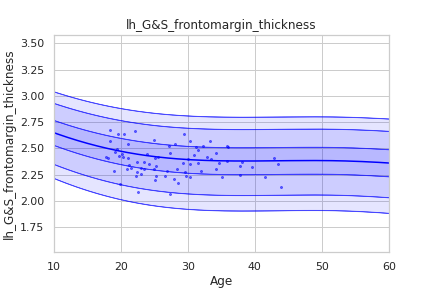

Running IDP 1 lh_G&S_occipital_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18082566]), 'Rho': array([0.2829863]), 'pRho': array([0.00131185]), 'SMSE': array([0.94301652]), 'EXPV': array([0.0570147])}


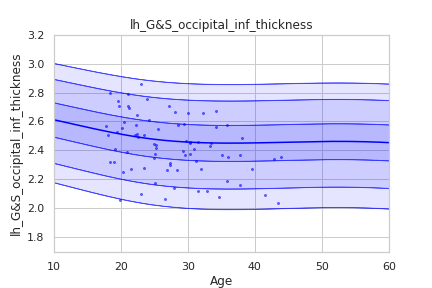

Running IDP 2 lh_G&S_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14701409]), 'Rho': array([0.15893808]), 'pRho': array([0.07663739]), 'SMSE': array([1.11497546]), 'EXPV': array([0.01257412])}


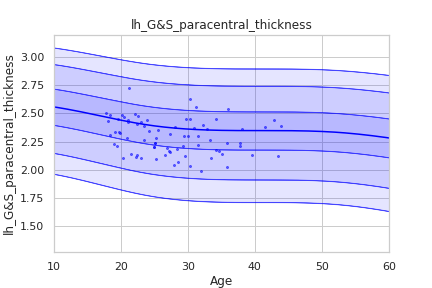

Running IDP 3 lh_G&S_subcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13089537]), 'Rho': array([0.37696355]), 'pRho': array([1.18866331e-05]), 'SMSE': array([0.91490988]), 'EXPV': array([0.14176862])}


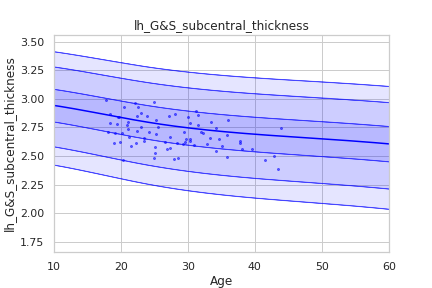

Running IDP 4 lh_G&S_transv_frontopol_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14135815]), 'Rho': array([0.21037783]), 'pRho': array([0.01832818]), 'SMSE': array([0.98354832]), 'EXPV': array([0.01666036])}


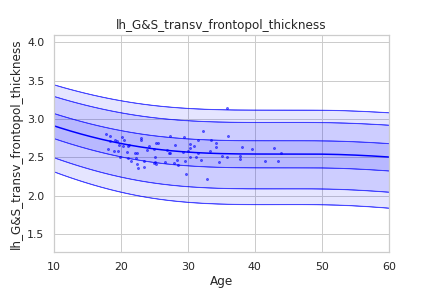

Running IDP 5 lh_G&S_cingul-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1134144]), 'Rho': array([0.26019642]), 'pRho': array([0.00326532]), 'SMSE': array([1.11183414]), 'EXPV': array([-0.03551133])}


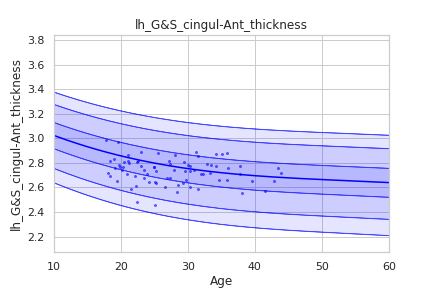

Running IDP 6 lh_G&S_cingul-Mid-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13629604]), 'Rho': array([0.29357654]), 'pRho': array([0.00083491]), 'SMSE': array([1.08464095]), 'EXPV': array([0.03582275])}


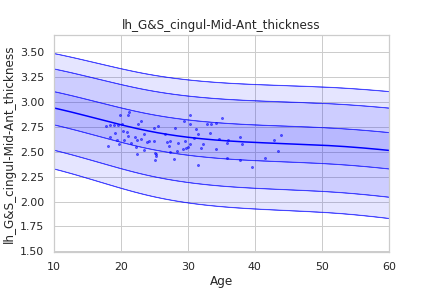

Running IDP 7 lh_G&S_cingul-Mid-Post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12226475]), 'Rho': array([0.21620435]), 'pRho': array([0.0152518]), 'SMSE': array([1.32049527]), 'EXPV': array([-0.14091074])}


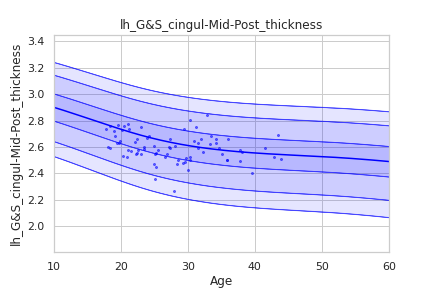

Running IDP 8 lh_G_cingul-Post-dorsal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13937754]), 'Rho': array([0.28880751]), 'pRho': array([0.00102564]), 'SMSE': array([0.99500362]), 'EXPV': array([0.03929969])}


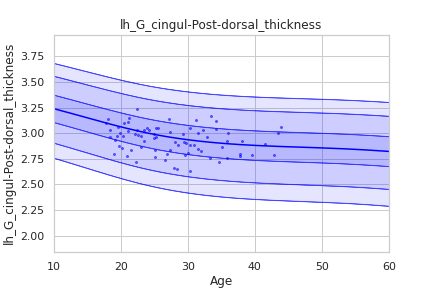

Running IDP 9 lh_G_cingul-Post-ventral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22335476]), 'Rho': array([0.18288892]), 'pRho': array([0.0410465]), 'SMSE': array([1.00180023]), 'EXPV': array([0.02488691])}


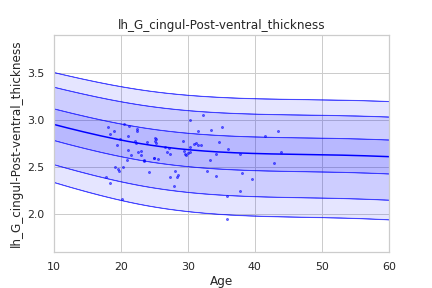

Running IDP 10 lh_G_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1175346]), 'Rho': array([0.10580064]), 'pRho': array([0.24079736]), 'SMSE': array([1.02285478]), 'EXPV': array([-0.01524789])}


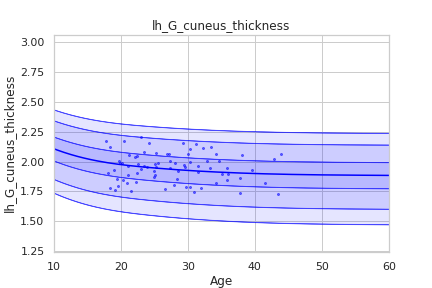

Running IDP 11 lh_G_front_inf-Opercular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14799182]), 'Rho': array([0.45391635]), 'pRho': array([6.37141219e-08]), 'SMSE': array([1.07135559]), 'EXPV': array([0.20591357])}


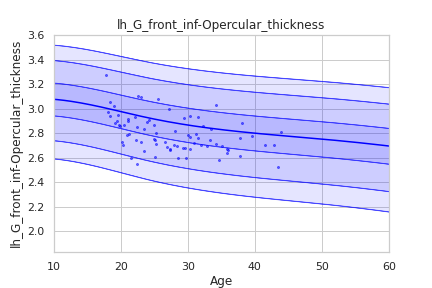

Running IDP 12 lh_G_front_inf-Orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20562659]), 'Rho': array([0.20537027]), 'pRho': array([0.02138529]), 'SMSE': array([1.27107252]), 'EXPV': array([0.00470167])}


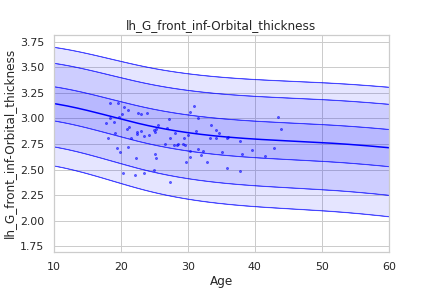

Running IDP 13 lh_G_front_inf-Triangul_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15400944]), 'Rho': array([0.23414994]), 'pRho': array([0.00840991]), 'SMSE': array([1.38404629]), 'EXPV': array([-0.02709573])}


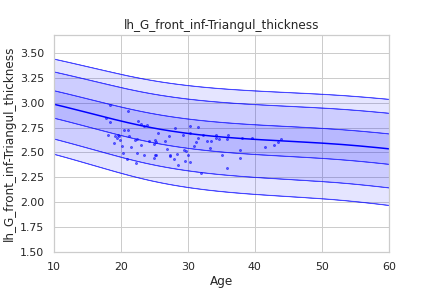

Running IDP 14 lh_G_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11688474]), 'Rho': array([0.27031908]), 'pRho': array([0.00219964]), 'SMSE': array([1.00240907]), 'EXPV': array([0.00967377])}


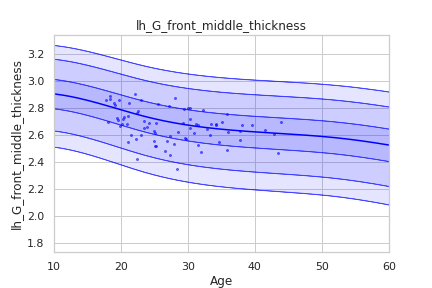

Running IDP 15 lh_G_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13276392]), 'Rho': array([0.25423143]), 'pRho': array([0.00409128]), 'SMSE': array([1.22771218]), 'EXPV': array([-0.04902349])}


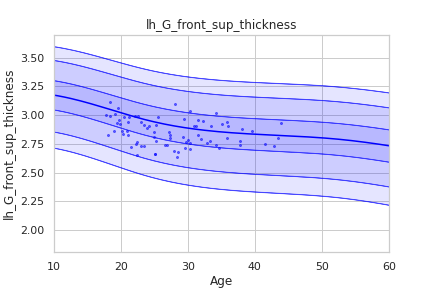

Running IDP 16 lh_G_Ins_lg&S_cent_ins_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.26552101]), 'Rho': array([0.25636882]), 'pRho': array([0.00377602]), 'SMSE': array([1.01638882]), 'EXPV': array([0.06201975])}


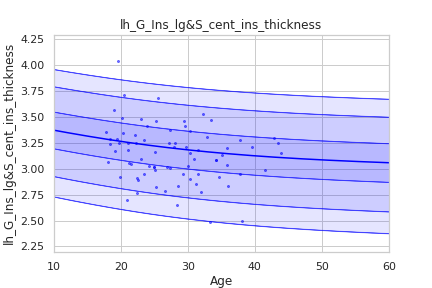

Running IDP 17 lh_G_insular_short_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18862596]), 'Rho': array([0.15869019]), 'pRho': array([0.07710603]), 'SMSE': array([1.22537547]), 'EXPV': array([-5.09089576e-05])}


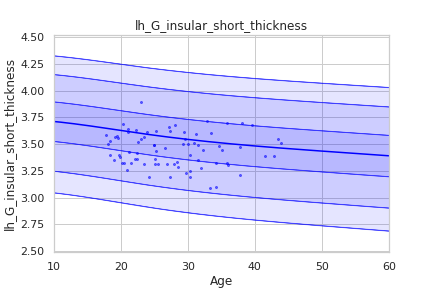

Running IDP 18 lh_G_occipital_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1594588]), 'Rho': array([0.23432253]), 'pRho': array([0.00836006]), 'SMSE': array([0.95949445]), 'EXPV': array([0.05211404])}


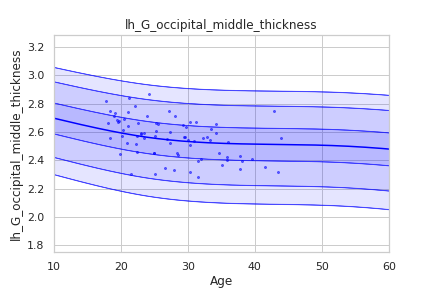

Running IDP 19 lh_G_occipital_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1409469]), 'Rho': array([0.2126935]), 'pRho': array([0.01704683]), 'SMSE': array([0.95536165]), 'EXPV': array([0.04508975])}


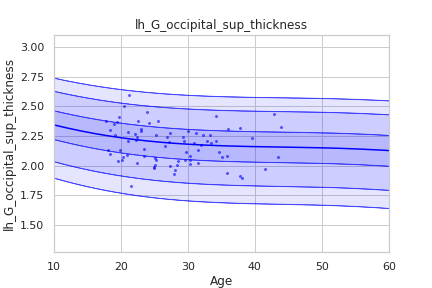

Running IDP 20 lh_G_oc-temp_lat-fusifor_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11747864]), 'Rho': array([0.20474216]), 'pRho': array([0.02179797]), 'SMSE': array([0.96229202]), 'EXPV': array([0.04122358])}


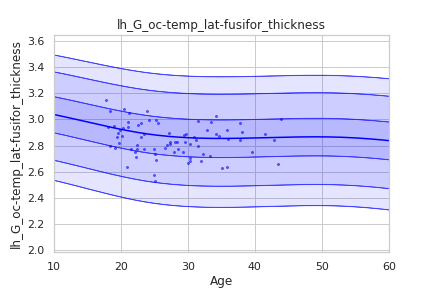

Running IDP 21 lh_G_oc-temp_med-Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13838278]), 'Rho': array([0.07731607]), 'pRho': array([0.39216833]), 'SMSE': array([1.00731318]), 'EXPV': array([-0.00534262])}


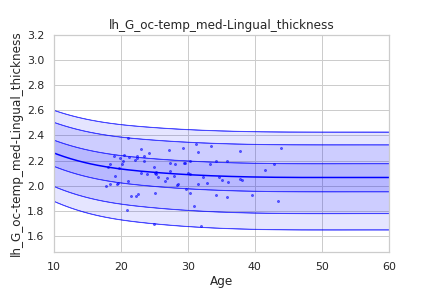

Running IDP 22 lh_G_oc-temp_med-Parahip_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16757359]), 'Rho': array([0.06543984]), 'pRho': array([0.46916332]), 'SMSE': array([1.13083325]), 'EXPV': array([-0.0007053])}


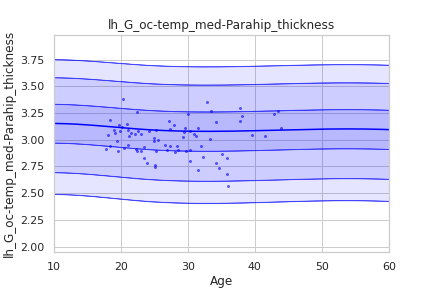

Running IDP 23 lh_G_orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12676886]), 'Rho': array([0.27610198]), 'pRho': array([0.00174278]), 'SMSE': array([1.21104377]), 'EXPV': array([0.03420587])}


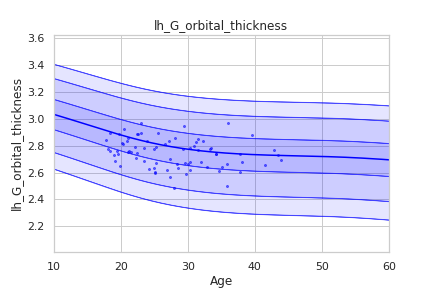

Running IDP 24 lh_G_pariet_inf-Angular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15462202]), 'Rho': array([0.26992364]), 'pRho': array([0.00223452]), 'SMSE': array([0.95501754]), 'EXPV': array([0.06974786])}


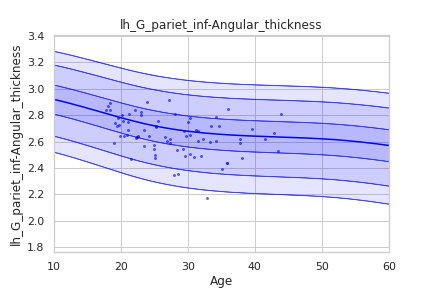

Running IDP 25 lh_G_pariet_inf-Supramar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12749767]), 'Rho': array([0.26160624]), 'pRho': array([0.00309341]), 'SMSE': array([1.04155339]), 'EXPV': array([0.0385957])}


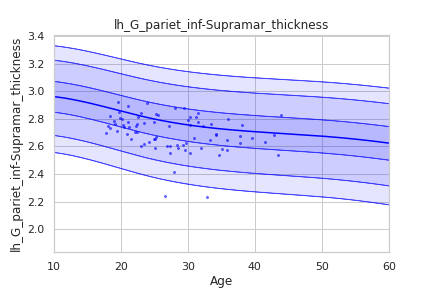

Running IDP 26 lh_G_parietal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12259127]), 'Rho': array([0.19977998]), 'pRho': array([0.02530446]), 'SMSE': array([1.03403935]), 'EXPV': array([0.00841722])}


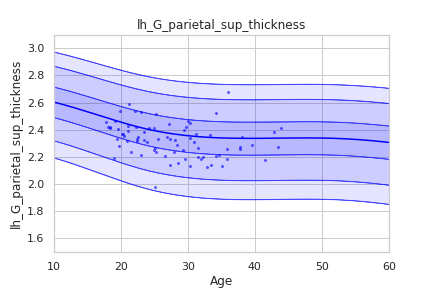

Running IDP 27 lh_G_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13932023]), 'Rho': array([0.14851342]), 'pRho': array([0.09841092]), 'SMSE': array([0.99909729]), 'EXPV': array([0.01603388])}


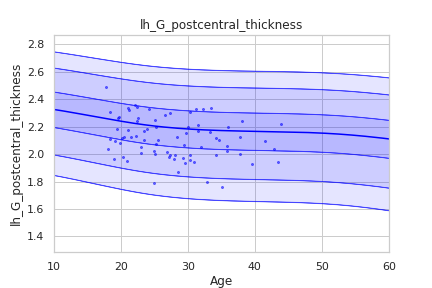

Running IDP 28 lh_G_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.22016823]), 'Rho': array([0.11591848]), 'pRho': array([0.1983932]), 'SMSE': array([1.12151835]), 'EXPV': array([0.00979684])}


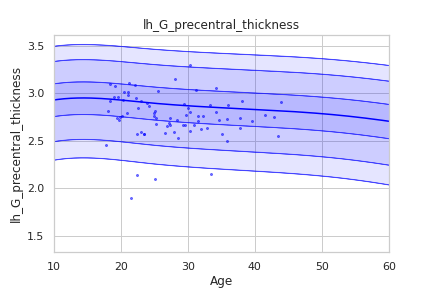

Running IDP 29 lh_G_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1282237]), 'Rho': array([0.17110721]), 'pRho': array([0.05629872]), 'SMSE': array([1.12136382]), 'EXPV': array([-0.05289039])}


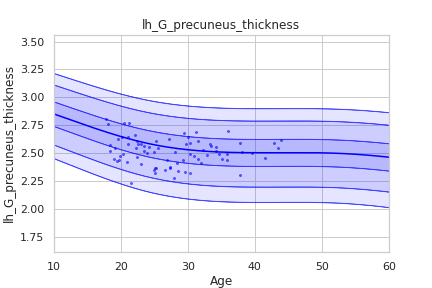

Running IDP 30 lh_G_rectus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14377518]), 'Rho': array([0.17918745]), 'pRho': array([0.04541498]), 'SMSE': array([0.98133787]), 'EXPV': array([0.02036965])}


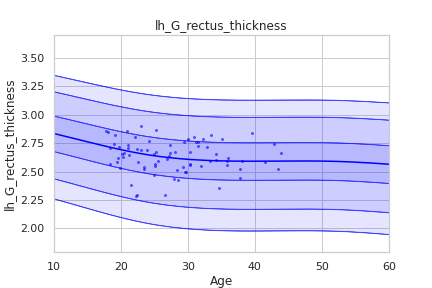

Running IDP 31 lh_G_subcallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1742373]), 'Rho': array([0.11186076]), 'pRho': array([0.21470369]), 'SMSE': array([1.05359642]), 'EXPV': array([-0.00331436])}


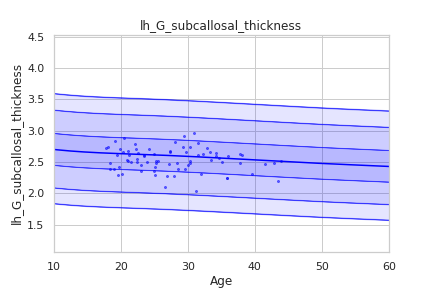

Running IDP 32 lh_G_temp_sup-G_T_transv_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18101082]), 'Rho': array([0.20223226]), 'pRho': array([0.02351577]), 'SMSE': array([1.01477985]), 'EXPV': array([0.02491693])}


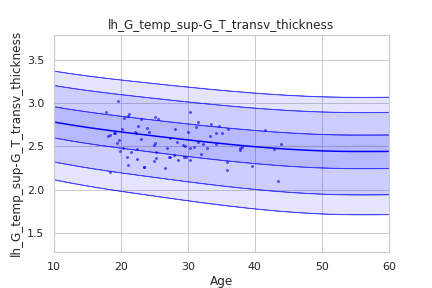

Running IDP 33 lh_G_temp_sup-Lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17250288]), 'Rho': array([0.18021101]), 'pRho': array([0.04417007]), 'SMSE': array([0.98667234]), 'EXPV': array([0.02807655])}


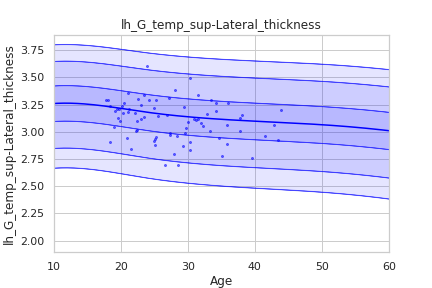

Running IDP 34 lh_G_temp_sup-Plan_polar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21809128]), 'Rho': array([0.18804829]), 'pRho': array([0.0355465]), 'SMSE': array([1.04464989]), 'EXPV': array([0.03535576])}


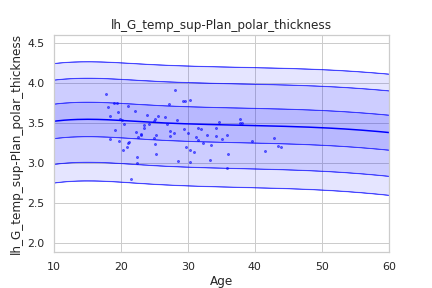

Running IDP 35 lh_G_temp_sup-Plan_tempo_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14187517]), 'Rho': array([0.13786299]), 'pRho': array([0.12539781]), 'SMSE': array([1.03031196]), 'EXPV': array([-0.02190082])}


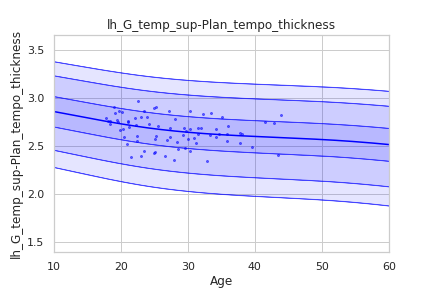

Running IDP 36 lh_G_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15013115]), 'Rho': array([0.31774486]), 'pRho': array([0.00027751]), 'SMSE': array([0.93686911]), 'EXPV': array([0.09291078])}


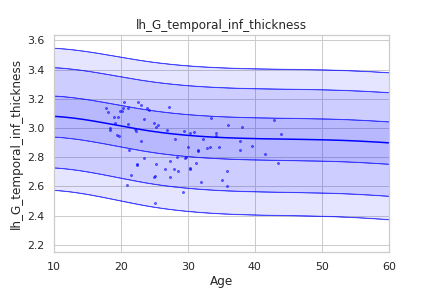

Running IDP 37 lh_G_temporal_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12986716]), 'Rho': array([0.39545438]), 'pRho': array([3.84272248e-06]), 'SMSE': array([0.84796398]), 'EXPV': array([0.15471224])}


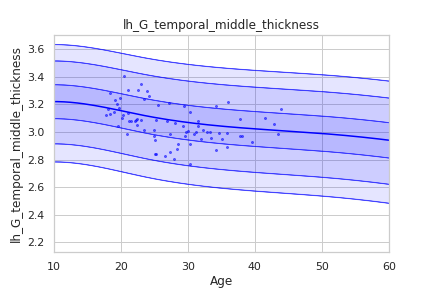

Running IDP 38 lh_Lat_Fis-ant-Horizont_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18166222]), 'Rho': array([0.16068318]), 'pRho': array([0.07340258]), 'SMSE': array([1.0173342]), 'EXPV': array([0.00367876])}


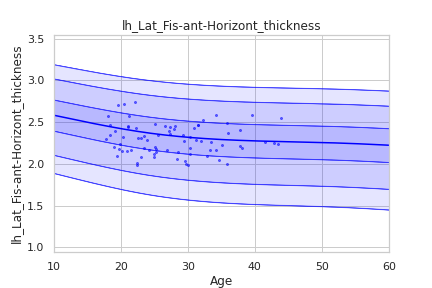

Running IDP 39 lh_Lat_Fis-ant-Vertical_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20089927]), 'Rho': array([0.21685327]), 'pRho': array([0.01493859]), 'SMSE': array([1.00065268]), 'EXPV': array([0.04255599])}


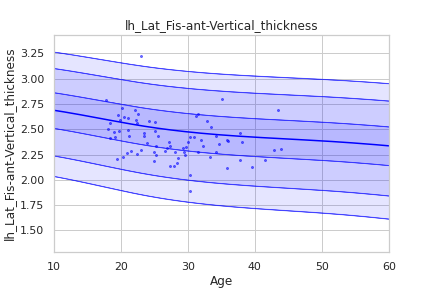

Running IDP 40 lh_Lat_Fis-post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12264584]), 'Rho': array([0.31068219]), 'pRho': array([0.00038688]), 'SMSE': array([1.06736388]), 'EXPV': array([0.06999013])}


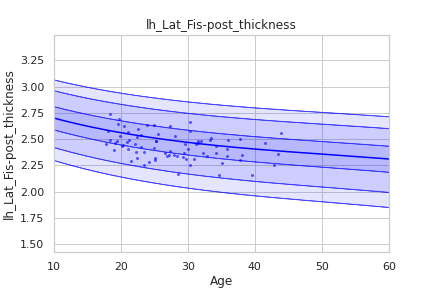

Running IDP 41 lh_Pole_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16533314]), 'Rho': array([0.27058799]), 'pRho': array([0.00217621]), 'SMSE': array([1.02147272]), 'EXPV': array([0.04435189])}


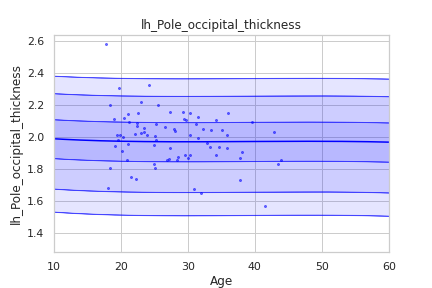

Running IDP 42 lh_Pole_temporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16506173]), 'Rho': array([0.10376173]), 'pRho': array([0.25005095]), 'SMSE': array([1.00810557]), 'EXPV': array([0.00995964])}


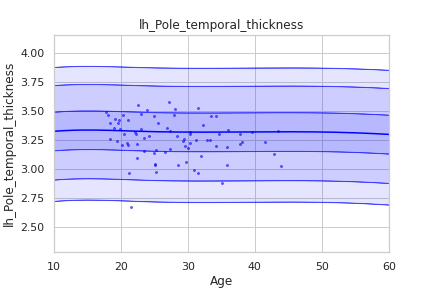

Running IDP 43 lh_S_calcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11206697]), 'Rho': array([0.2258618]), 'pRho': array([0.01113306]), 'SMSE': array([0.98196661]), 'EXPV': array([0.02827202])}


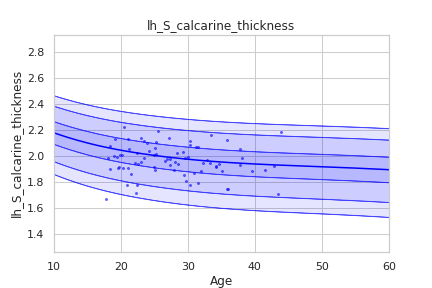

Running IDP 44 lh_S_central_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.09644103]), 'Rho': array([0.06876451]), 'pRho': array([0.44681872]), 'SMSE': array([1.12366255]), 'EXPV': array([-0.02083899])}


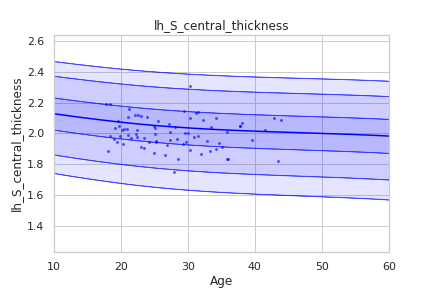

Running IDP 45 lh_S_cingul-Marginalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10761737]), 'Rho': array([0.32254357]), 'pRho': array([0.00022033]), 'SMSE': array([1.09644049]), 'EXPV': array([0.03404818])}


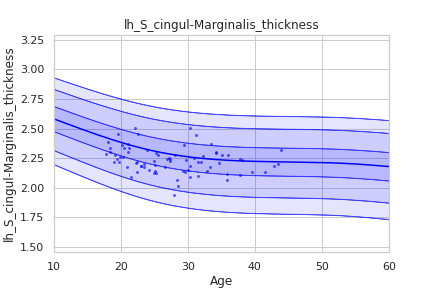

Running IDP 46 lh_S_circular_insula_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17716318]), 'Rho': array([0.31135599]), 'pRho': array([0.00037495]), 'SMSE': array([1.24647526]), 'EXPV': array([0.08245103])}


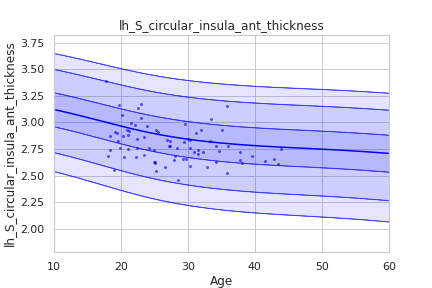

Running IDP 47 lh_S_circular_insula_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1723574]), 'Rho': array([0.43583417]), 'pRho': array([2.4823431e-07]), 'SMSE': array([0.92725391]), 'EXPV': array([0.18873192])}


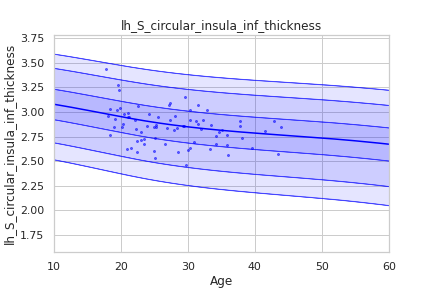

Running IDP 48 lh_S_circular_insula_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12005408]), 'Rho': array([0.37029737]), 'pRho': array([1.75419679e-05]), 'SMSE': array([1.1874891]), 'EXPV': array([0.09193806])}


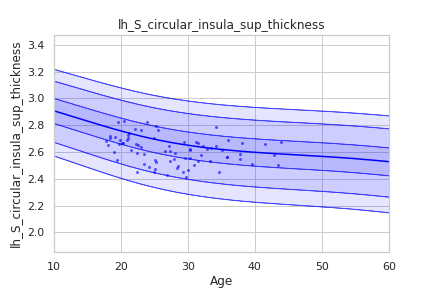

Running IDP 49 lh_S_collat_transv_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17719668]), 'Rho': array([0.03430809]), 'pRho': array([0.70461807]), 'SMSE': array([1.12913692]), 'EXPV': array([-0.04451208])}


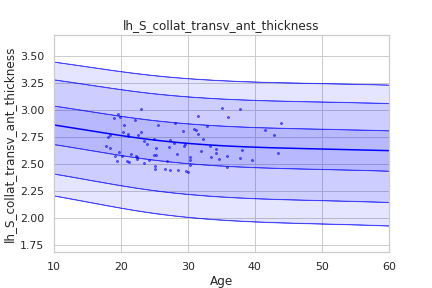

Running IDP 50 lh_S_collat_transv_post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13725779]), 'Rho': array([0.26947681]), 'pRho': array([0.00227452]), 'SMSE': array([0.94971141]), 'EXPV': array([0.07251092])}


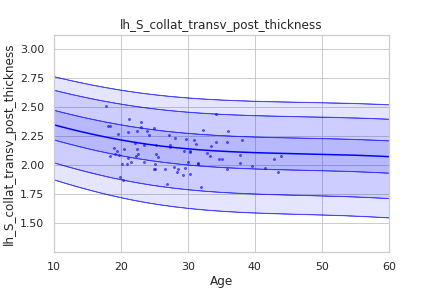

Running IDP 51 lh_S_front_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11391195]), 'Rho': array([0.26108674]), 'pRho': array([0.00315579]), 'SMSE': array([1.28882212]), 'EXPV': array([-0.02472439])}


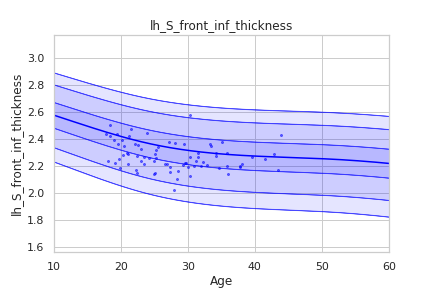

Running IDP 52 lh_S_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10169445]), 'Rho': array([0.25567449]), 'pRho': array([0.00387596]), 'SMSE': array([1.06544528]), 'EXPV': array([0.00267525])}


Running IDP 53 lh_S_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1041579]), 'Rho': array([0.2381992]), 'pRho': array([0.00730694]), 'SMSE': array([1.19410857]), 'EXPV': array([-0.04817639])}


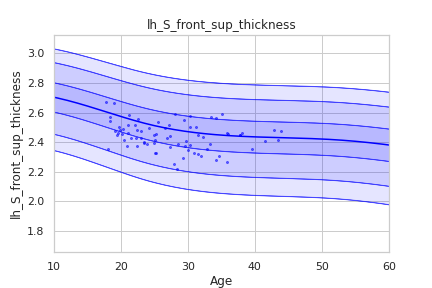

Running IDP 54 lh_S_interm_prim-Jensen_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15506896]), 'Rho': array([0.23436874]), 'pRho': array([0.00834676]), 'SMSE': array([1.02858596]), 'EXPV': array([0.05310609])}


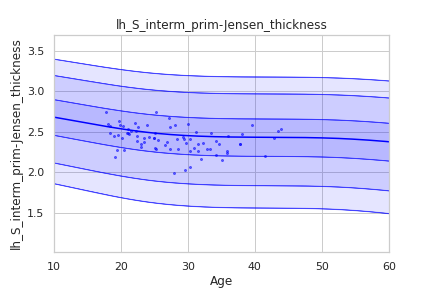

Running IDP 55 lh_S_intrapariet&P_trans_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10367591]), 'Rho': array([0.26460989]), 'pRho': array([0.00275397]), 'SMSE': array([0.96752442]), 'EXPV': array([0.04534821])}


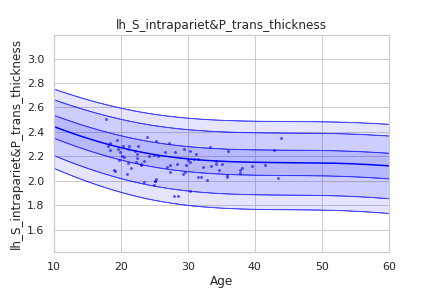

Running IDP 56 lh_S_oc_middle&Lunatus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13657483]), 'Rho': array([0.16497663]), 'pRho': array([0.06591022]), 'SMSE': array([0.97406296]), 'EXPV': array([0.02636753])}


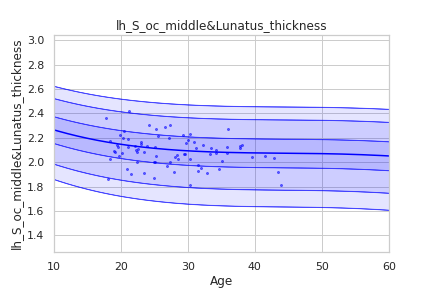

Running IDP 57 lh_S_oc_sup&transversal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.09867285]), 'Rho': array([0.25286602]), 'pRho': array([0.00430478]), 'SMSE': array([0.95305247]), 'EXPV': array([0.05412722])}


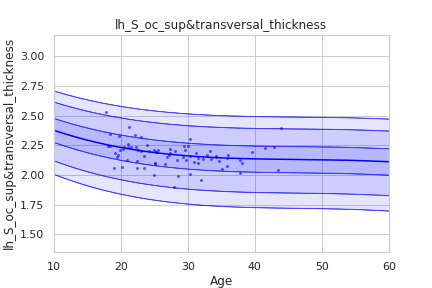

Running IDP 58 lh_S_occipital_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14938776]), 'Rho': array([0.12131899]), 'pRho': array([0.17809461]), 'SMSE': array([1.01805226]), 'EXPV': array([0.00077395])}


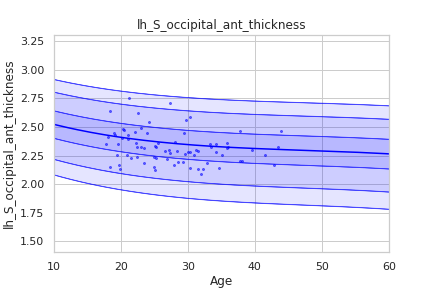

Running IDP 59 lh_S_oc-temp_lat_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12599527]), 'Rho': array([0.35016893]), 'pRho': array([5.37746821e-05]), 'SMSE': array([0.99460528]), 'EXPV': array([0.12081773])}


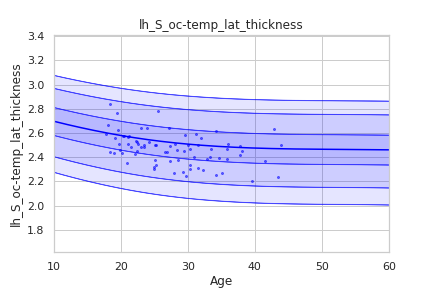

Running IDP 60 lh_S_oc-temp_med&Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10986807]), 'Rho': array([0.14558553]), 'pRho': array([0.10532846]), 'SMSE': array([1.0826733]), 'EXPV': array([-0.04286895])}


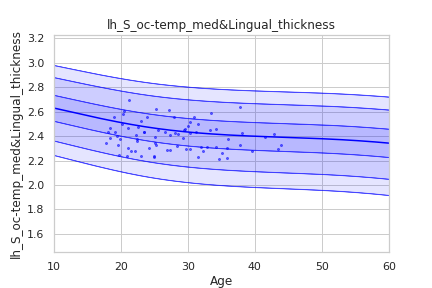

Running IDP 61 lh_S_orbital_lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13304037]), 'Rho': array([0.29175399]), 'pRho': array([0.00090361]), 'SMSE': array([1.05956817]), 'EXPV': array([0.08492663])}


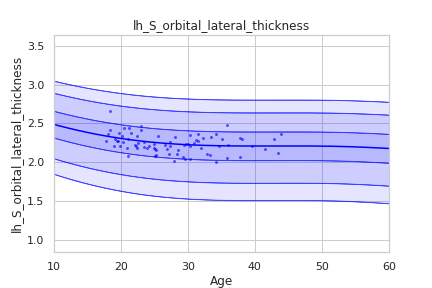

Running IDP 62 lh_S_orbital_med-olfact_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13623895]), 'Rho': array([0.26560161]), 'pRho': array([0.00264948]), 'SMSE': array([0.97160563]), 'EXPV': array([0.07012315])}


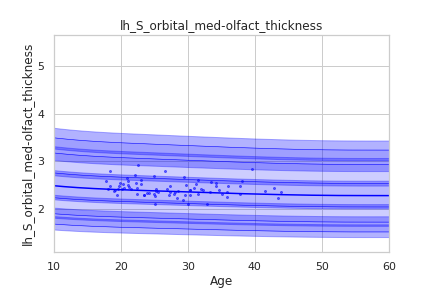

Running IDP 63 lh_S_orbital-H_Shaped_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12827882]), 'Rho': array([0.24249336]), 'pRho': array([0.00627869]), 'SMSE': array([1.37084345]), 'EXPV': array([0.02593532])}


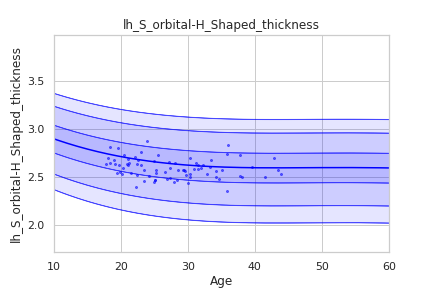

Running IDP 64 lh_S_parieto_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10921094]), 'Rho': array([0.22310125]), 'pRho': array([0.01219727]), 'SMSE': array([1.08474352]), 'EXPV': array([-0.01049359])}


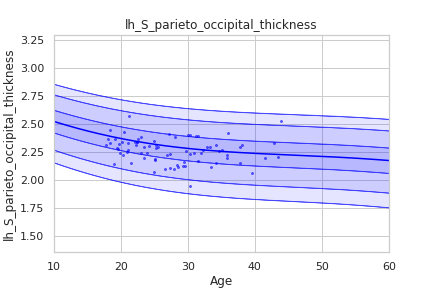

Running IDP 65 lh_S_pericallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14597719]), 'Rho': array([0.06675277]), 'pRho': array([0.46026745]), 'SMSE': array([1.16189089]), 'EXPV': array([-0.05016719])}


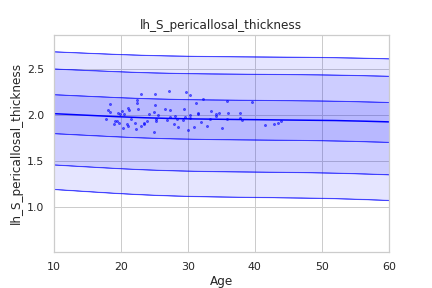

Running IDP 66 lh_S_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10782581]), 'Rho': array([0.11534556]), 'pRho': array([0.20064043]), 'SMSE': array([1.1524342]), 'EXPV': array([-0.13864808])}


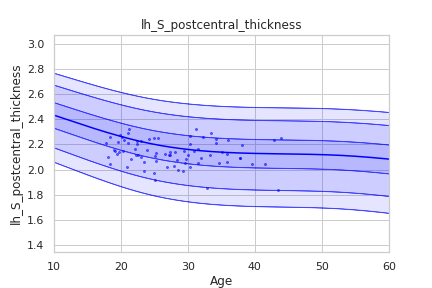

Running IDP 67 lh_S_precentral-inf-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14327626]), 'Rho': array([0.26064185]), 'pRho': array([0.0032101]), 'SMSE': array([1.27100079]), 'EXPV': array([0.04308041])}


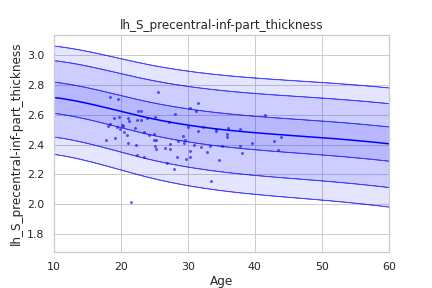

Running IDP 68 lh_S_precentral-sup-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16814831]), 'Rho': array([0.09393018]), 'pRho': array([0.2980797]), 'SMSE': array([1.33206658]), 'EXPV': array([-0.06262641])}


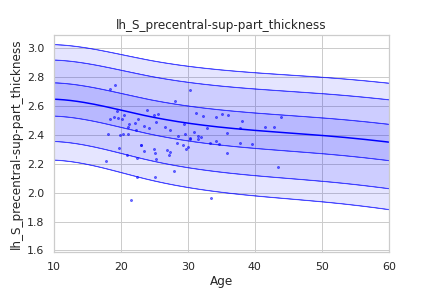

Running IDP 69 lh_S_suborbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20309566]), 'Rho': array([0.11413834]), 'pRho': array([0.2054354]), 'SMSE': array([1.01672362]), 'EXPV': array([-0.00766549])}


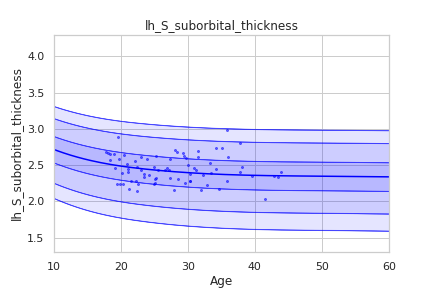

Running IDP 70 lh_S_subparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1068918]), 'Rho': array([0.2249688]), 'pRho': array([0.01146807]), 'SMSE': array([1.12635708]), 'EXPV': array([-0.00887625])}


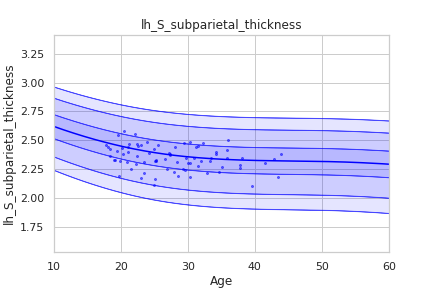

Running IDP 71 lh_S_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11079143]), 'Rho': array([0.26681436]), 'pRho': array([0.00252656]), 'SMSE': array([0.94836853]), 'EXPV': array([0.06128466])}


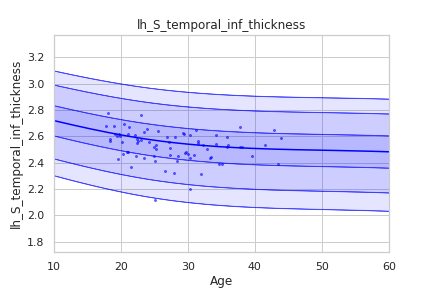

Running IDP 72 lh_S_temporal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10235021]), 'Rho': array([0.40328218]), 'pRho': array([2.32869986e-06]), 'SMSE': array([0.9194167]), 'EXPV': array([0.14900777])}


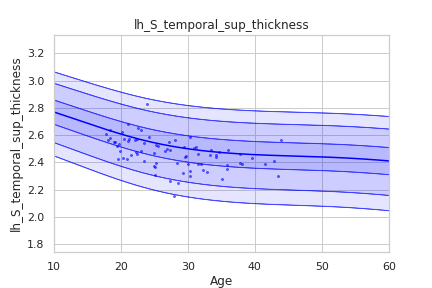

Running IDP 73 lh_S_temporal_transverse_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.23597081]), 'Rho': array([0.017201]), 'pRho': array([0.8493013]), 'SMSE': array([1.18886796]), 'EXPV': array([-0.07153098])}


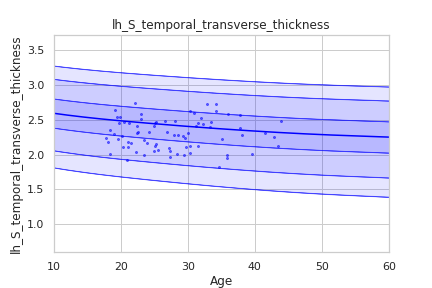

Running IDP 74 rh_G&S_frontomargin_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12938233]), 'Rho': array([0.33581151]), 'pRho': array([0.00011392]), 'SMSE': array([1.00782554]), 'EXPV': array([0.10843068])}


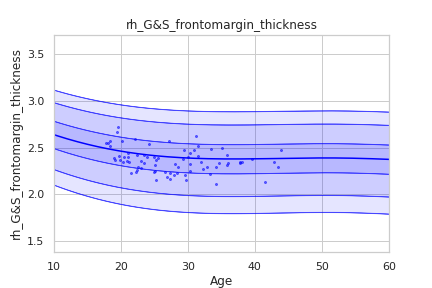

Running IDP 75 rh_G&S_occipital_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15282822]), 'Rho': array([0.25571419]), 'pRho': array([0.00387018]), 'SMSE': array([0.94277453]), 'EXPV': array([0.0591763])}


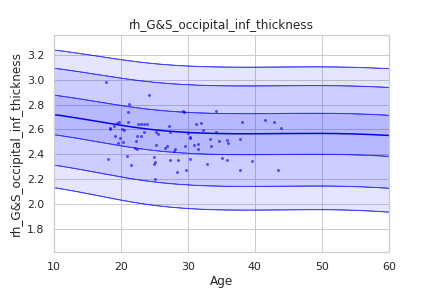

Running IDP 76 rh_G&S_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13843662]), 'Rho': array([0.0457134]), 'pRho': array([0.61336695]), 'SMSE': array([1.09655276]), 'EXPV': array([-0.05661733])}


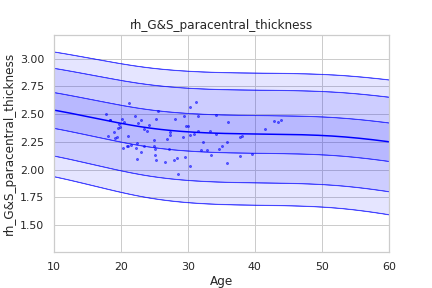

Running IDP 77 rh_G&S_subcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1342067]), 'Rho': array([0.3156578]), 'pRho': array([0.00030642]), 'SMSE': array([0.90702586]), 'EXPV': array([0.0929914])}


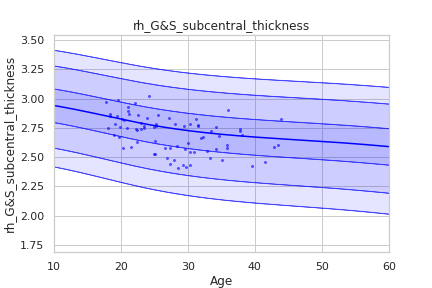

Running IDP 78 rh_G&S_transv_frontopol_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13932585]), 'Rho': array([0.17530264]), 'pRho': array([0.05040751]), 'SMSE': array([1.08483579]), 'EXPV': array([-0.0235554])}


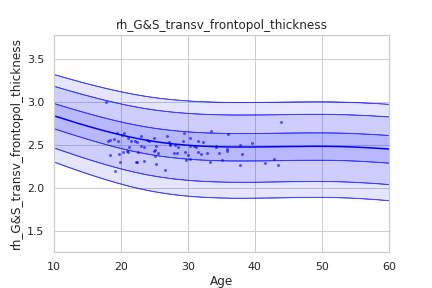

Running IDP 79 rh_G&S_cingul-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12219447]), 'Rho': array([0.33569955]), 'pRho': array([0.00011457]), 'SMSE': array([0.97694921]), 'EXPV': array([0.09271233])}


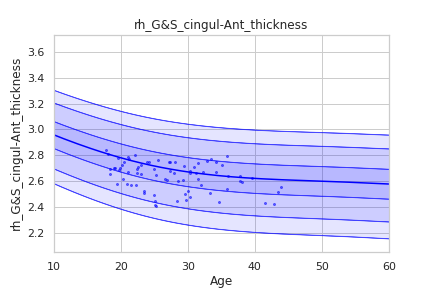

Running IDP 80 rh_G&S_cingul-Mid-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1245613]), 'Rho': array([0.27243651]), 'pRho': array([0.00202113]), 'SMSE': array([1.13038628]), 'EXPV': array([0.00890239])}


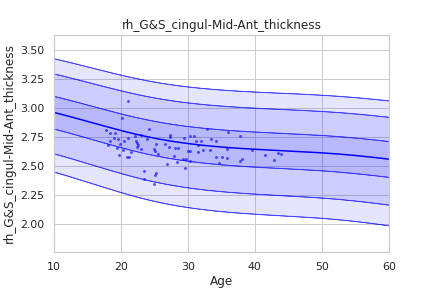

Running IDP 81 rh_G&S_cingul-Mid-Post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10717078]), 'Rho': array([0.36797823]), 'pRho': array([2.00419922e-05]), 'SMSE': array([0.92088135]), 'EXPV': array([0.10323938])}


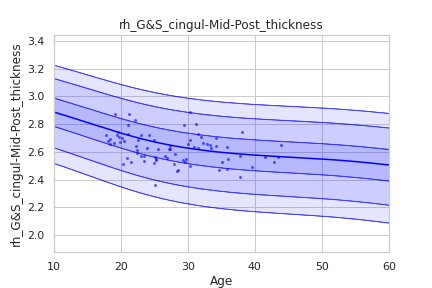

Running IDP 82 rh_G_cingul-Post-dorsal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13257959]), 'Rho': array([0.19270032]), 'pRho': array([0.03113109]), 'SMSE': array([1.08017228]), 'EXPV': array([-0.06718476])}


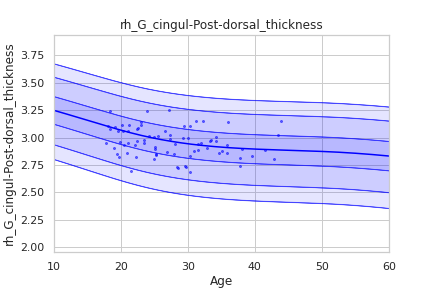

Running IDP 83 rh_G_cingul-Post-ventral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21918322]), 'Rho': array([0.12070415]), 'pRho': array([0.18032568]), 'SMSE': array([1.04402897]), 'EXPV': array([-0.02617011])}


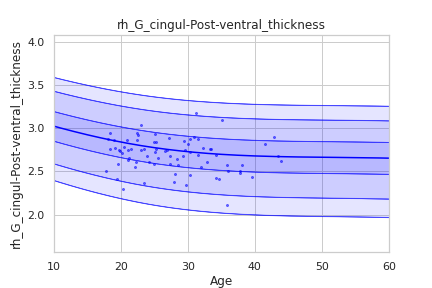

Running IDP 84 rh_G_cuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14178119]), 'Rho': array([0.16343397]), 'pRho': array([0.06852748]), 'SMSE': array([0.97597445]), 'EXPV': array([0.02452955])}


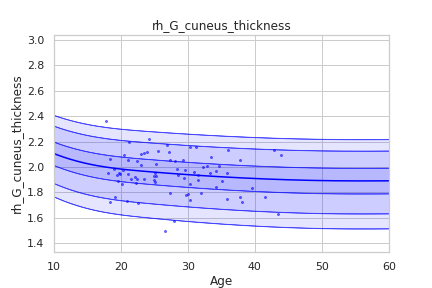

Running IDP 85 rh_G_front_inf-Opercular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14474298]), 'Rho': array([0.46876444]), 'pRho': array([1.94968592e-08]), 'SMSE': array([0.99470152]), 'EXPV': array([0.21955566])}


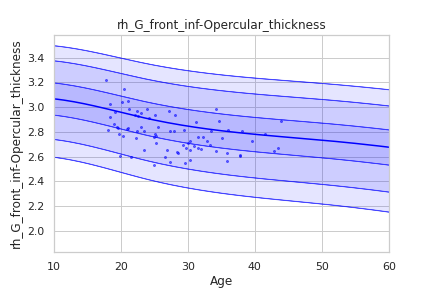

Running IDP 86 rh_G_front_inf-Orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19293242]), 'Rho': array([0.43638853]), 'pRho': array([2.3840345e-07]), 'SMSE': array([1.05254318]), 'EXPV': array([0.18622709])}


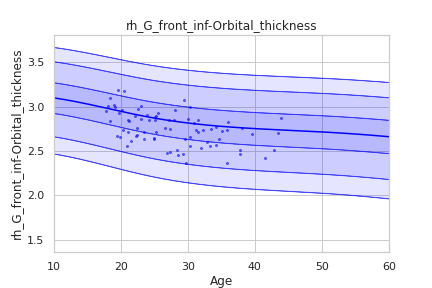

Running IDP 87 rh_G_front_inf-Triangul_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15318053]), 'Rho': array([0.38272105]), 'pRho': array([8.42955885e-06]), 'SMSE': array([0.97024028]), 'EXPV': array([0.14108869])}


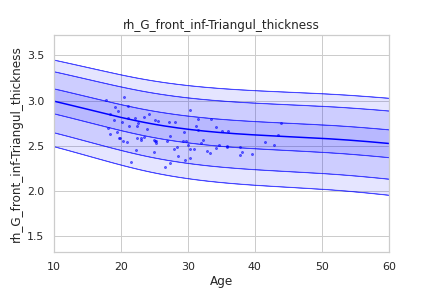

Running IDP 88 rh_G_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11638621]), 'Rho': array([0.4123584]), 'pRho': array([1.28000916e-06]), 'SMSE': array([0.97231943]), 'EXPV': array([0.15991277])}


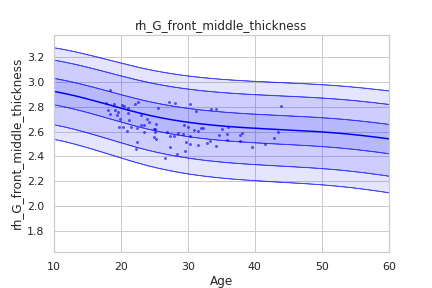

Running IDP 89 rh_G_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12522724]), 'Rho': array([0.36618845]), 'pRho': array([2.21956694e-05]), 'SMSE': array([1.10060815]), 'EXPV': array([0.09466294])}


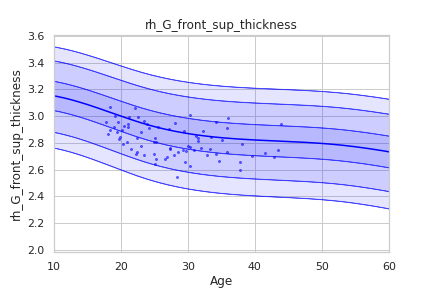

Running IDP 90 rh_G_Ins_lg&S_cent_ins_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18412398]), 'Rho': array([0.26195798]), 'pRho': array([0.00305181]), 'SMSE': array([0.9971763]), 'EXPV': array([0.06862125])}


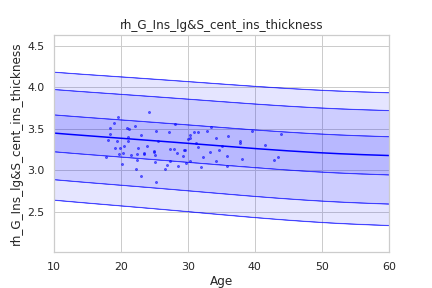

Running IDP 91 rh_G_insular_short_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21201881]), 'Rho': array([0.27898943]), 'pRho': array([0.00154846]), 'SMSE': array([1.09533903]), 'EXPV': array([0.0761023])}


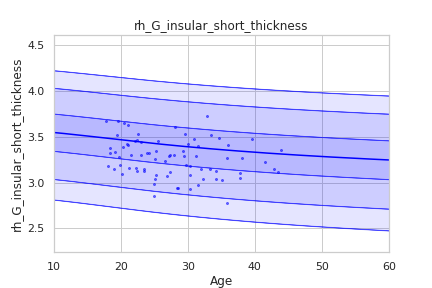

Running IDP 92 rh_G_occipital_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12881605]), 'Rho': array([0.34536163]), 'pRho': array([6.94445242e-05]), 'SMSE': array([0.89518117]), 'EXPV': array([0.11193091])}


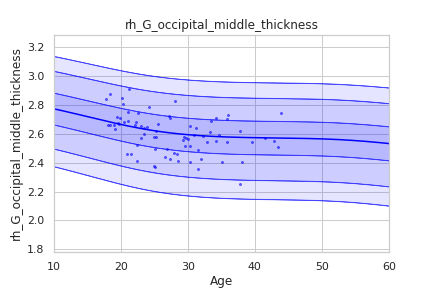

Running IDP 93 rh_G_occipital_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.157431]), 'Rho': array([0.19789557]), 'pRho': array([0.02675649]), 'SMSE': array([0.9671659]), 'EXPV': array([0.03888492])}


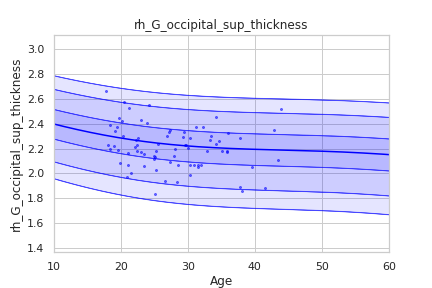

Running IDP 94 rh_G_oc-temp_lat-fusifor_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13115019]), 'Rho': array([0.15406314]), 'pRho': array([0.08628263]), 'SMSE': array([0.98549212]), 'EXPV': array([0.01674043])}


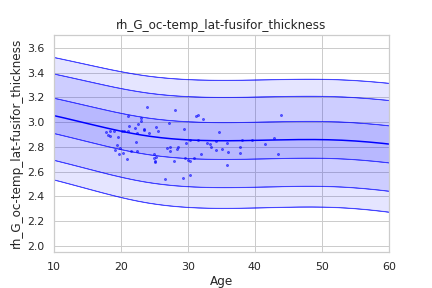

Running IDP 95 rh_G_oc-temp_med-Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14430591]), 'Rho': array([0.09521111]), 'pRho': array([0.29150022]), 'SMSE': array([1.01745115]), 'EXPV': array([-0.00248454])}


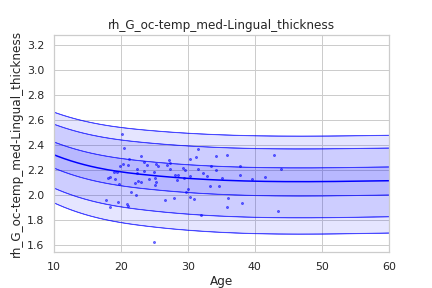

Running IDP 96 rh_G_oc-temp_med-Parahip_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16235561]), 'Rho': array([-0.02596078]), 'pRho': array([0.77425731]), 'SMSE': array([1.14914058]), 'EXPV': array([-0.024714])}


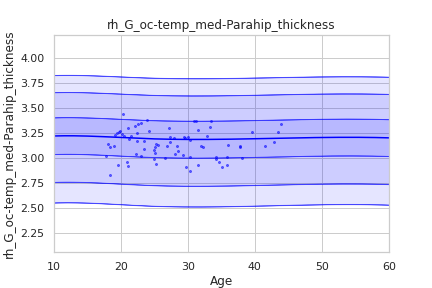

Running IDP 97 rh_G_orbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12839846]), 'Rho': array([0.35278745]), 'pRho': array([4.66945368e-05]), 'SMSE': array([1.12780112]), 'EXPV': array([0.11346632])}


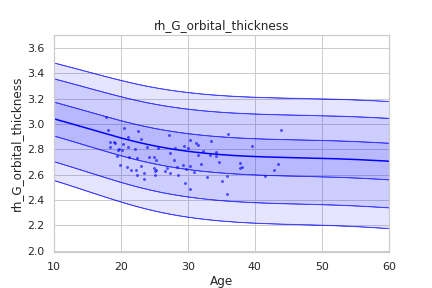

Running IDP 98 rh_G_pariet_inf-Angular_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12352803]), 'Rho': array([0.36954959]), 'pRho': array([1.83141985e-05]), 'SMSE': array([0.8709957]), 'EXPV': array([0.13602387])}


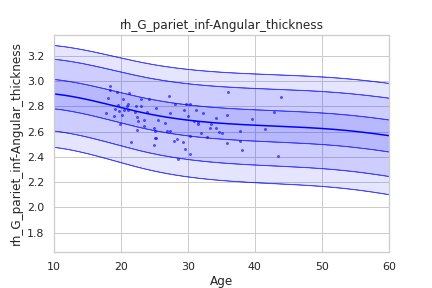

Running IDP 99 rh_G_pariet_inf-Supramar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12458312]), 'Rho': array([0.36416512]), 'pRho': array([2.4890774e-05]), 'SMSE': array([0.89491457]), 'EXPV': array([0.12899718])}


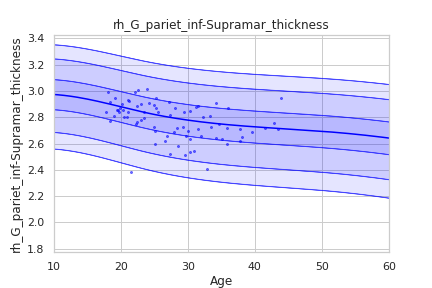

Running IDP 100 rh_G_parietal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1069664]), 'Rho': array([0.21858853]), 'pRho': array([0.0141283]), 'SMSE': array([1.02811229]), 'EXPV': array([-0.00772739])}


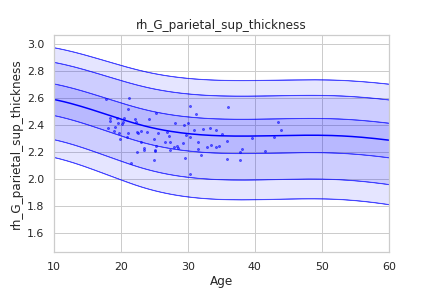

Running IDP 101 rh_G_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12484417]), 'Rho': array([0.19700281]), 'pRho': array([0.02746874]), 'SMSE': array([1.0090679]), 'EXPV': array([0.03613813])}


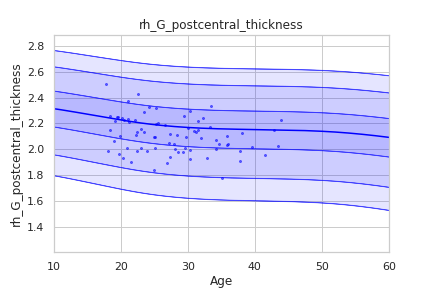

Running IDP 102 rh_G_precentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16751637]), 'Rho': array([0.17535869]), 'pRho': array([0.05033239]), 'SMSE': array([1.00850326]), 'EXPV': array([0.02947408])}


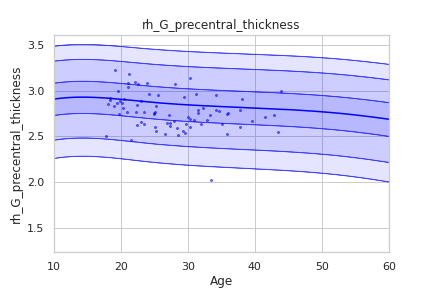

Running IDP 103 rh_G_precuneus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1148001]), 'Rho': array([0.2501412]), 'pRho': array([0.00476077]), 'SMSE': array([1.04961265]), 'EXPV': array([0.00915005])}


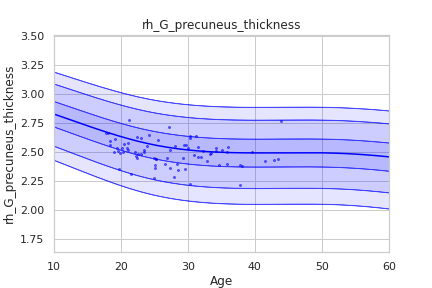

Running IDP 104 rh_G_rectus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13208321]), 'Rho': array([0.26136995]), 'pRho': array([0.00312164]), 'SMSE': array([0.94083309]), 'EXPV': array([0.06442588])}


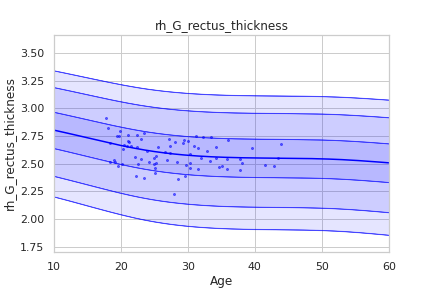

Running IDP 105 rh_G_subcallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18454197]), 'Rho': array([0.16951346]), 'pRho': array([0.05867952]), 'SMSE': array([1.06715926]), 'EXPV': array([0.02872166])}


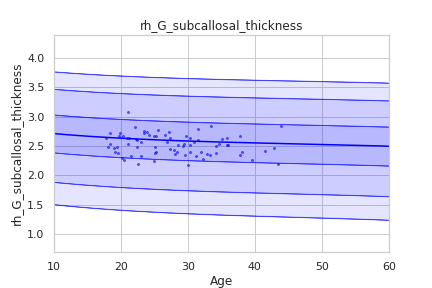

Running IDP 106 rh_G_temp_sup-G_T_transv_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.18702198]), 'Rho': array([0.10051845]), 'pRho': array([0.26526856]), 'SMSE': array([1.12569531]), 'EXPV': array([-0.03377863])}


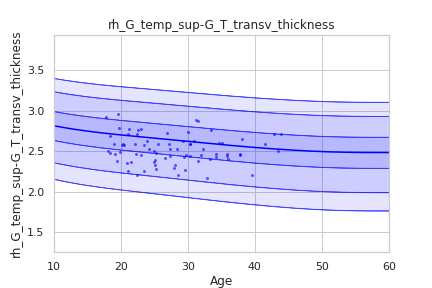

Running IDP 107 rh_G_temp_sup-Lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16019014]), 'Rho': array([0.21598049]), 'pRho': array([0.01536116]), 'SMSE': array([1.01052816]), 'EXPV': array([0.03734073])}


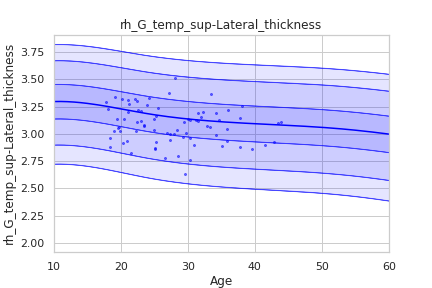

Running IDP 108 rh_G_temp_sup-Plan_polar_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20851991]), 'Rho': array([0.18291925]), 'pRho': array([0.04101221]), 'SMSE': array([0.99956286]), 'EXPV': array([0.03195542])}


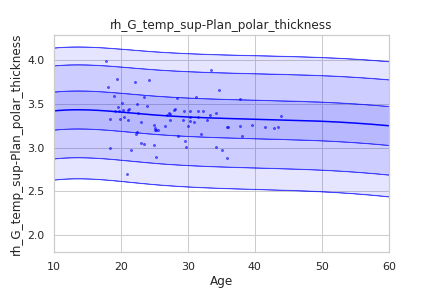

Running IDP 109 rh_G_temp_sup-Plan_tempo_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14974581]), 'Rho': array([0.16051109]), 'pRho': array([0.07371661]), 'SMSE': array([0.99534067]), 'EXPV': array([0.00499685])}


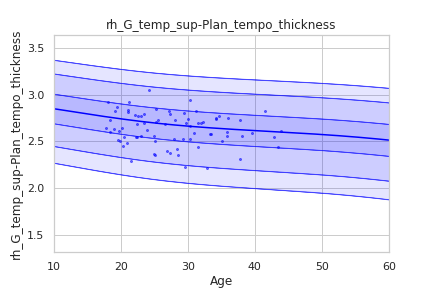

Running IDP 110 rh_G_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14934948]), 'Rho': array([0.33055339]), 'pRho': array([0.00014853]), 'SMSE': array([0.9272371]), 'EXPV': array([0.10081155])}


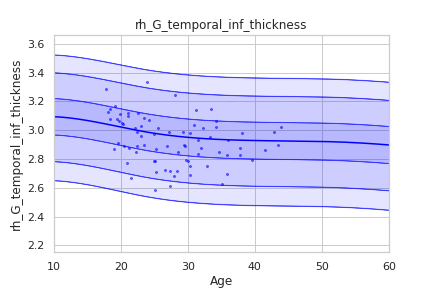

Running IDP 111 rh_G_temporal_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14557301]), 'Rho': array([0.38223351]), 'pRho': array([8.68085843e-06]), 'SMSE': array([0.86440727]), 'EXPV': array([0.1451598])}


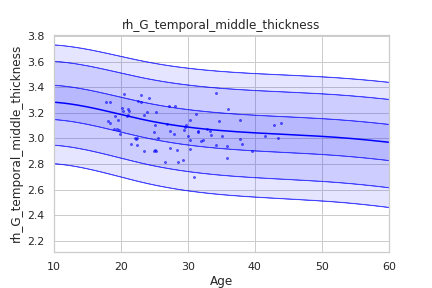

Running IDP 112 rh_Lat_Fis-ant-Horizont_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.20016713]), 'Rho': array([0.12097183]), 'pRho': array([0.17935188]), 'SMSE': array([1.04525468]), 'EXPV': array([-0.01736136])}


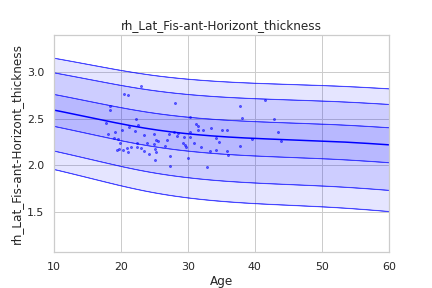

Running IDP 113 rh_Lat_Fis-ant-Vertical_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15742369]), 'Rho': array([0.42923216]), 'pRho': array([3.99230955e-07]), 'SMSE': array([0.84343608]), 'EXPV': array([0.17301907])}


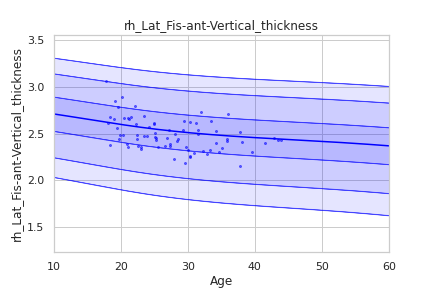

Running IDP 114 rh_Lat_Fis-post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10819526]), 'Rho': array([0.30119471]), 'pRho': array([0.00059636]), 'SMSE': array([0.98753401]), 'EXPV': array([0.02767293])}


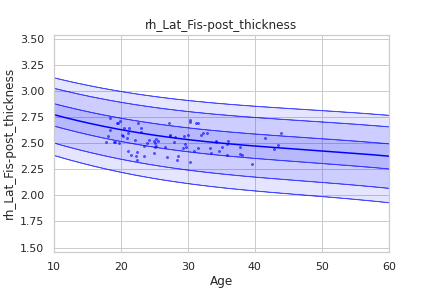

Running IDP 115 rh_Pole_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.19416432]), 'Rho': array([0.20136594]), 'pRho': array([0.02413492]), 'SMSE': array([0.99235643]), 'EXPV': array([0.03000586])}


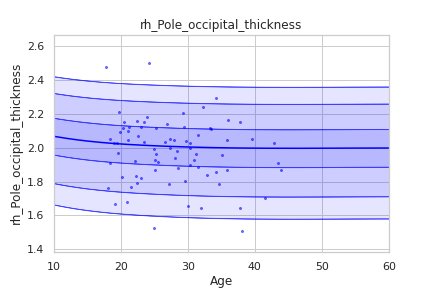

Running IDP 116 rh_Pole_temporal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1680859]), 'Rho': array([0.01723921]), 'pRho': array([0.84897047]), 'SMSE': array([1.0190829]), 'EXPV': array([-0.00887194])}


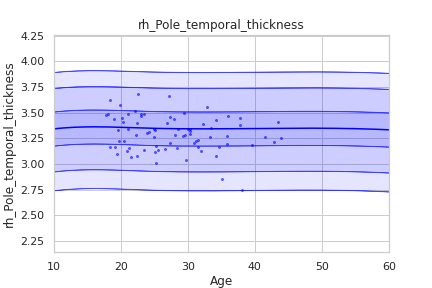

Running IDP 117 rh_S_calcarine_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12027041]), 'Rho': array([0.17917234]), 'pRho': array([0.04543356]), 'SMSE': array([1.00274615]), 'EXPV': array([-0.00197258])}


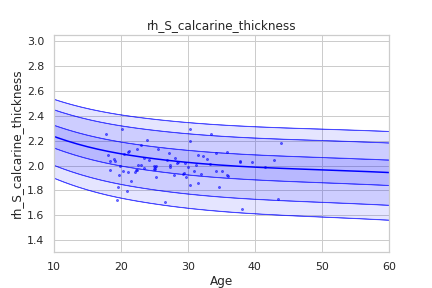

Running IDP 118 rh_S_central_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1036433]), 'Rho': array([0.09373566]), 'pRho': array([0.29908732]), 'SMSE': array([1.10115716]), 'EXPV': array([-0.00067736])}


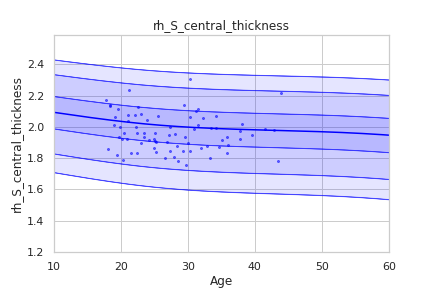

Running IDP 119 rh_S_cingul-Marginalis_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11278092]), 'Rho': array([0.20675829]), 'pRho': array([0.02049702]), 'SMSE': array([1.12767351]), 'EXPV': array([-0.06938889])}


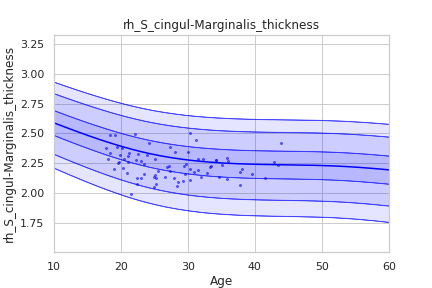

Running IDP 120 rh_S_circular_insula_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15550707]), 'Rho': array([0.38893947]), 'pRho': array([5.76932079e-06]), 'SMSE': array([0.9161764]), 'EXPV': array([0.15094495])}


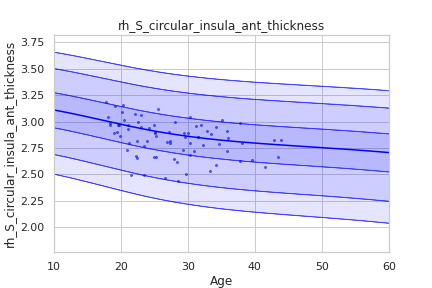

Running IDP 121 rh_S_circular_insula_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15946056]), 'Rho': array([0.38244227]), 'pRho': array([8.57240275e-06]), 'SMSE': array([0.95373545]), 'EXPV': array([0.14480606])}


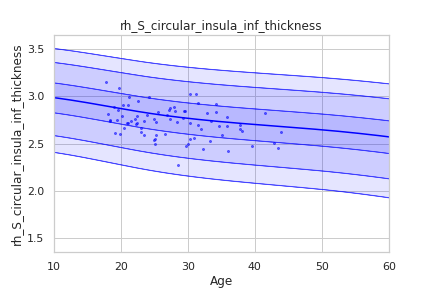

Running IDP 122 rh_S_circular_insula_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.130515]), 'Rho': array([0.43474627]), 'pRho': array([2.68658319e-07]), 'SMSE': array([1.15453077]), 'EXPV': array([0.17071979])}


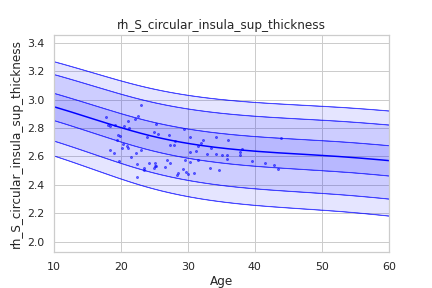

Running IDP 123 rh_S_collat_transv_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.16865724]), 'Rho': array([0.25905448]), 'pRho': array([0.00341078]), 'SMSE': array([1.12909912]), 'EXPV': array([0.0671079])}


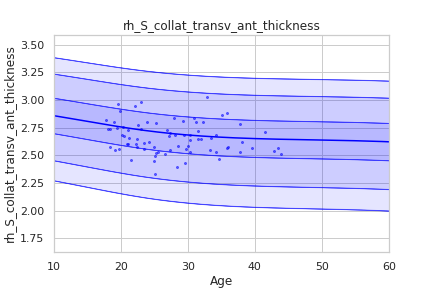

Running IDP 124 rh_S_collat_transv_post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12253775]), 'Rho': array([0.3488548]), 'pRho': array([5.76938734e-05]), 'SMSE': array([0.87982344]), 'EXPV': array([0.12169722])}


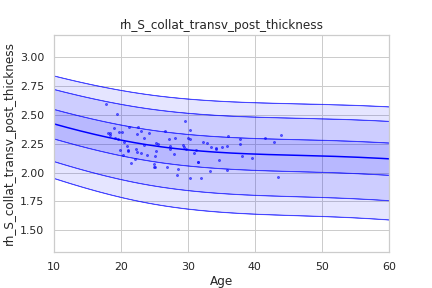

Running IDP 125 rh_S_front_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10461421]), 'Rho': array([0.38618976]), 'pRho': array([6.829581e-06]), 'SMSE': array([0.97733576]), 'EXPV': array([0.13292518])}


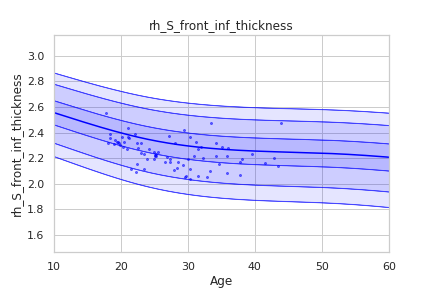

Running IDP 126 rh_S_front_middle_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10793222]), 'Rho': array([0.35866891]), 'pRho': array([3.38394919e-05]), 'SMSE': array([0.93756186]), 'EXPV': array([0.12620393])}


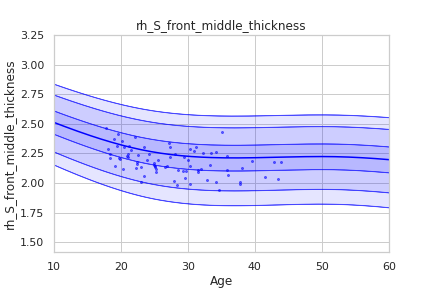

Running IDP 127 rh_S_front_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11104167]), 'Rho': array([0.31548093]), 'pRho': array([0.00030899]), 'SMSE': array([1.10223876]), 'EXPV': array([0.07511904])}


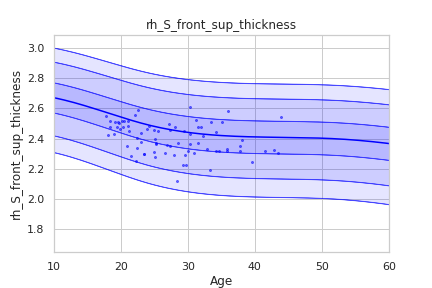

Running IDP 128 rh_S_interm_prim-Jensen_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21138156]), 'Rho': array([0.16384704]), 'pRho': array([0.06781858]), 'SMSE': array([1.06947208]), 'EXPV': array([0.02222317])}


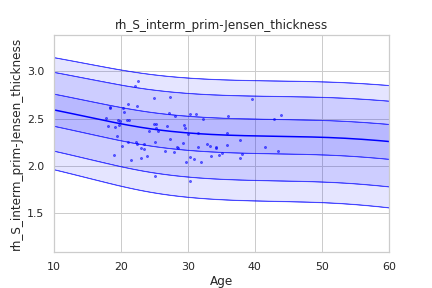

Running IDP 129 rh_S_intrapariet&P_trans_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.09406486]), 'Rho': array([0.20443905]), 'pRho': array([0.02199954]), 'SMSE': array([1.06370029]), 'EXPV': array([-0.04754793])}


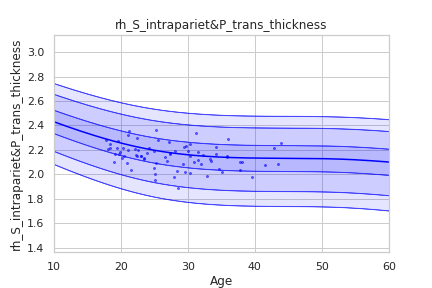

Running IDP 130 rh_S_oc_middle&Lunatus_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1200909]), 'Rho': array([0.25098776]), 'pRho': array([0.0046147]), 'SMSE': array([0.94041085]), 'EXPV': array([0.06295291])}


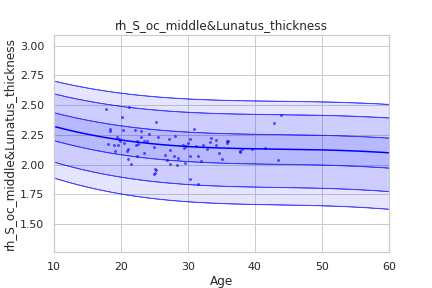

Running IDP 131 rh_S_oc_sup&transversal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10969775]), 'Rho': array([0.22252404]), 'pRho': array([0.01243067]), 'SMSE': array([0.97340033]), 'EXPV': array([0.02969826])}


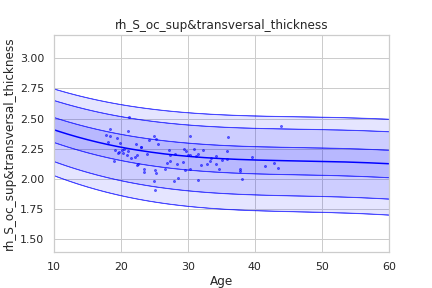

Running IDP 132 rh_S_occipital_ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13156313]), 'Rho': array([0.29190192]), 'pRho': array([0.00089785]), 'SMSE': array([0.92477315]), 'EXPV': array([0.08446329])}


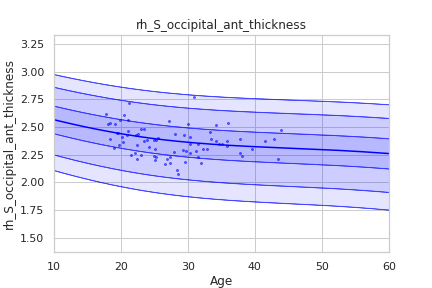

Running IDP 133 rh_S_oc-temp_lat_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14289348]), 'Rho': array([0.34537477]), 'pRho': array([6.93964257e-05]), 'SMSE': array([1.03419866]), 'EXPV': array([0.11467403])}


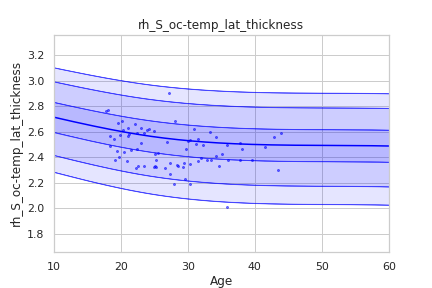

Running IDP 134 rh_S_oc-temp_med&Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11255133]), 'Rho': array([0.19282422]), 'pRho': array([0.03102013]), 'SMSE': array([1.1061133]), 'EXPV': array([-0.00441936])}


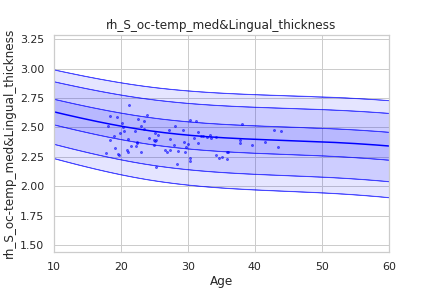

Running IDP 135 rh_S_orbital_lateral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14277713]), 'Rho': array([0.30807991]), 'pRho': array([0.0004363]), 'SMSE': array([0.9249029]), 'EXPV': array([0.09435487])}


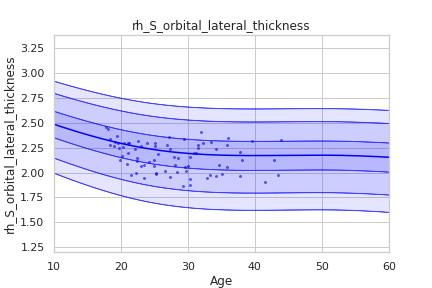

Running IDP 136 rh_S_orbital_med-olfact_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13602381]), 'Rho': array([0.33180278]), 'pRho': array([0.00013952]), 'SMSE': array([0.89442465]), 'EXPV': array([0.10914795])}


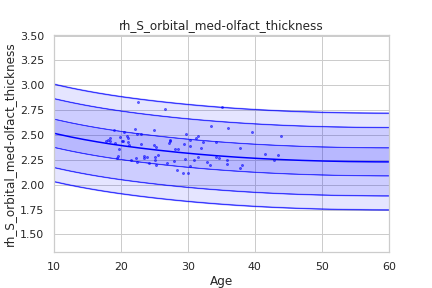

Running IDP 137 rh_S_orbital-H_Shaped_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11114044]), 'Rho': array([0.35252356]), 'pRho': array([4.73665182e-05]), 'SMSE': array([0.98002646]), 'EXPV': array([0.11641499])}


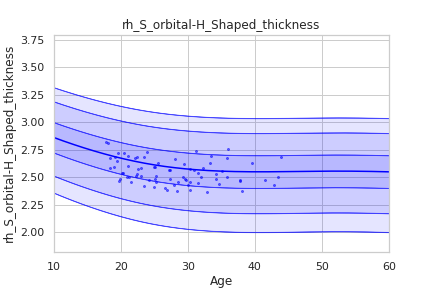

Running IDP 138 rh_S_parieto_occipital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11507983]), 'Rho': array([0.29951094]), 'pRho': array([0.00064294]), 'SMSE': array([0.96568862]), 'EXPV': array([0.07583377])}


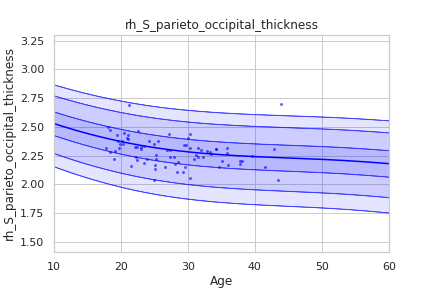

Running IDP 139 rh_S_pericallosal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13141613]), 'Rho': array([0.14603704]), 'pRho': array([0.10423764]), 'SMSE': array([1.11511724]), 'EXPV': array([-0.00389663])}


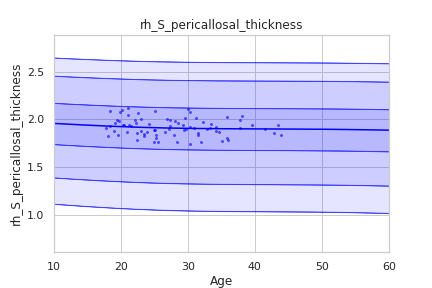

Running IDP 140 rh_S_postcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.09869185]), 'Rho': array([0.26009163]), 'pRho': array([0.00327843]), 'SMSE': array([1.08978794]), 'EXPV': array([-0.00243195])}


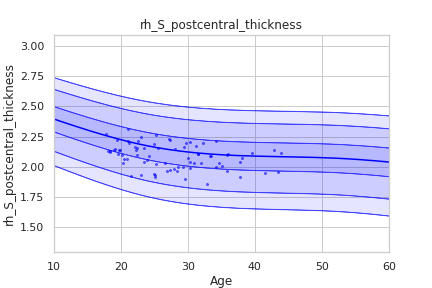

Running IDP 141 rh_S_precentral-inf-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12643658]), 'Rho': array([0.37307876]), 'pRho': array([1.49295329e-05]), 'SMSE': array([1.04647664]), 'EXPV': array([0.13774113])}


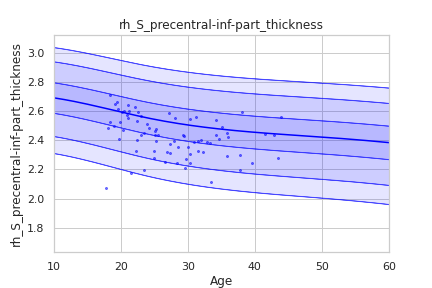

Running IDP 142 rh_S_precentral-sup-part_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13039026]), 'Rho': array([0.15664038]), 'pRho': array([0.08106984]), 'SMSE': array([1.13169119]), 'EXPV': array([-0.03370359])}


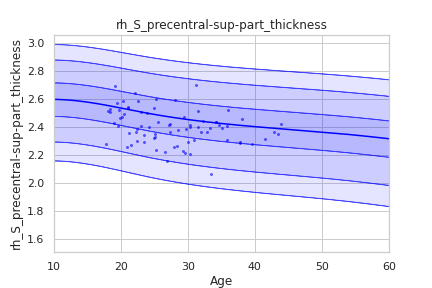

Running IDP 143 rh_S_suborbital_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.17721598]), 'Rho': array([0.13904889]), 'pRho': array([0.12213839]), 'SMSE': array([1.02061262]), 'EXPV': array([-0.00773442])}


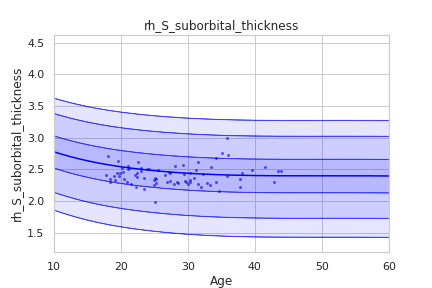

Running IDP 144 rh_S_subparietal_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10450043]), 'Rho': array([0.32607858]), 'pRho': array([0.0001854]), 'SMSE': array([0.94603099]), 'EXPV': array([0.08279385])}


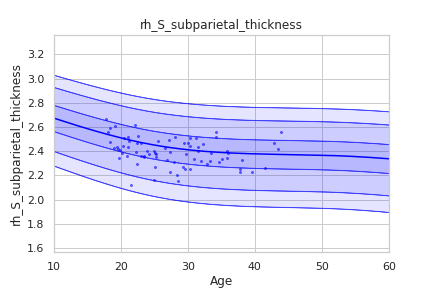

Running IDP 145 rh_S_temporal_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.10506085]), 'Rho': array([0.3790186]), 'pRho': array([1.05229237e-05]), 'SMSE': array([0.87843124]), 'EXPV': array([0.14347267])}


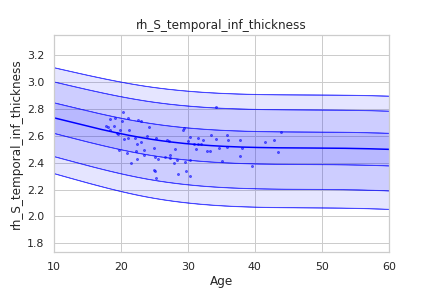

Running IDP 146 rh_S_temporal_sup_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.08463333]), 'Rho': array([0.42409751]), 'pRho': array([5.73340218e-07]), 'SMSE': array([0.91441498]), 'EXPV': array([0.12854985])}


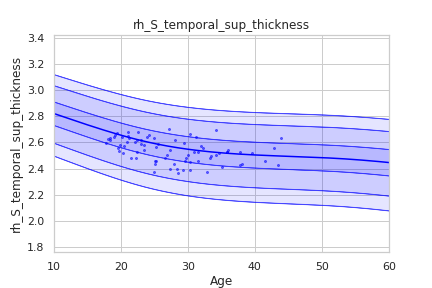

Running IDP 147 rh_S_temporal_transverse_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.21258242]), 'Rho': array([0.10939664]), 'pRho': array([0.22506079]), 'SMSE': array([1.03327929]), 'EXPV': array([-0.01662196])}


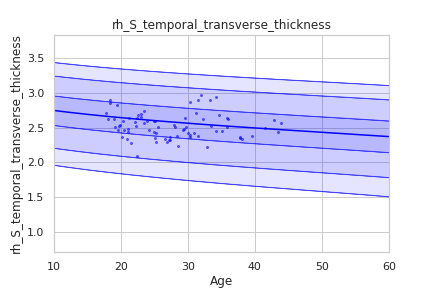

Running IDP 148 Left-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([4107.40497656]), 'Rho': array([0.13172168]), 'pRho': array([0.14335338]), 'SMSE': array([1.0343867]), 'EXPV': array([0.00642346])}


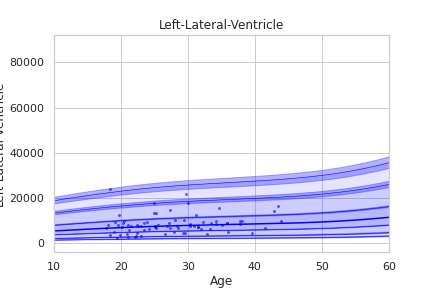

Running IDP 149 Left-Inf-Lat-Vent :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([186.92089014]), 'Rho': array([0.18209575]), 'pRho': array([0.04195187]), 'SMSE': array([1.03917614]), 'EXPV': array([0.02877075])}


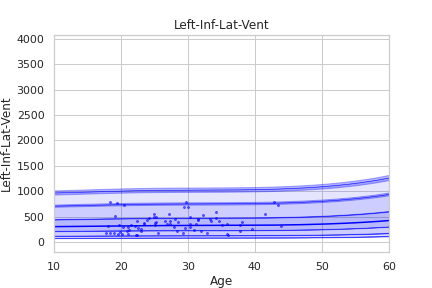

Running IDP 150 Left-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2008.499758]), 'Rho': array([0.49340443]), 'pRho': array([2.36421111e-09]), 'SMSE': array([0.83299881]), 'EXPV': array([0.16921294])}


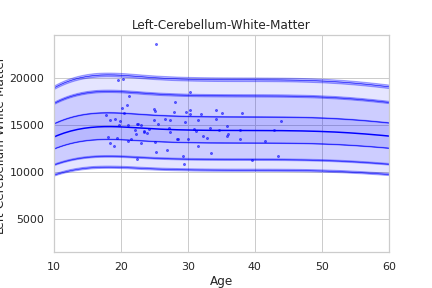

Running IDP 151 Left-Cerebellum-Cortex :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([5719.1458478]), 'Rho': array([0.56338699]), 'pRho': array([1.86095304e-12]), 'SMSE': array([0.69863882]), 'EXPV': array([0.30821072])}


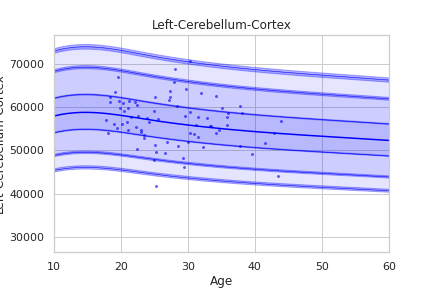

Running IDP 152 Left-Thalamus-Proper :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([750.68122513]), 'Rho': array([0.48558345]), 'pRho': array([4.71400261e-09]), 'SMSE': array([0.7976744]), 'EXPV': array([0.23505209])}


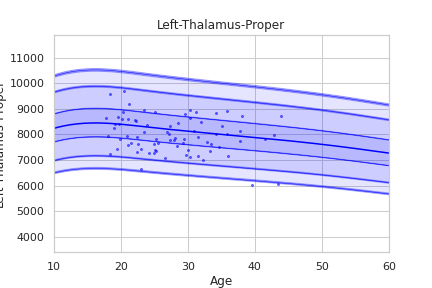

Running IDP 153 Left-Caudate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([449.04559476]), 'Rho': array([0.29425467]), 'pRho': array([0.0008106]), 'SMSE': array([0.92790303]), 'EXPV': array([0.0725066])}


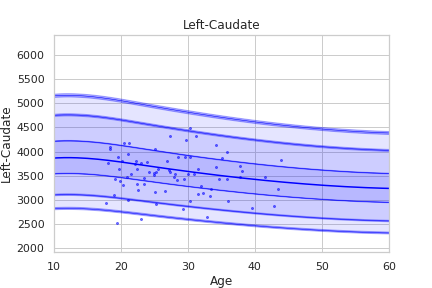

Running IDP 154 Left-Putamen :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([590.89875616]), 'Rho': array([0.41978411]), 'pRho': array([7.73152812e-07]), 'SMSE': array([0.89628736]), 'EXPV': array([0.17388899])}


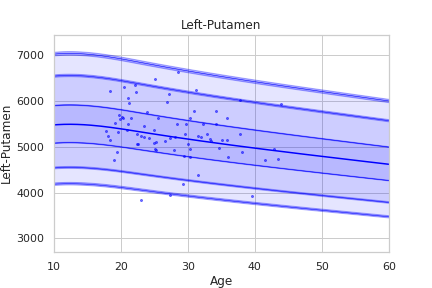

Running IDP 155 Left-Pallidum :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([231.19228295]), 'Rho': array([0.3875237]), 'pRho': array([6.29417841e-06]), 'SMSE': array([0.90004142]), 'EXPV': array([0.15017127])}


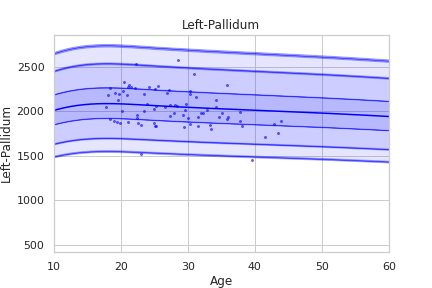

Running IDP 156 3rd-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([417.75939916]), 'Rho': array([0.27459363]), 'pRho': array([0.00185282]), 'SMSE': array([1.09140693]), 'EXPV': array([0.07417139])}


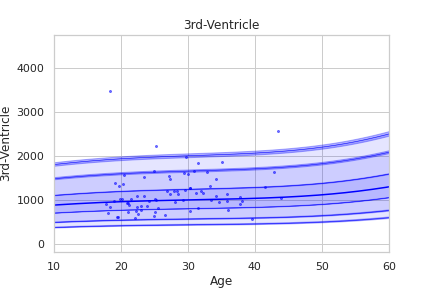

Running IDP 157 4th-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([653.61464843]), 'Rho': array([0.27909021]), 'pRho': array([0.00154205]), 'SMSE': array([0.97397608]), 'EXPV': array([0.07265174])}


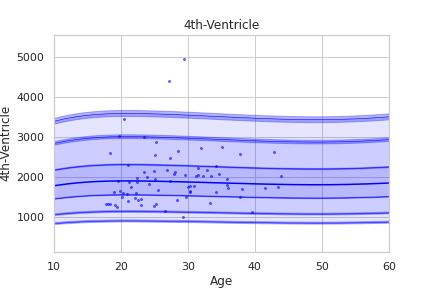

Running IDP 158 Brain-Stem :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2107.90262409]), 'Rho': array([0.48492861]), 'pRho': array([4.99000559e-09]), 'SMSE': array([0.79714381]), 'EXPV': array([0.23439849])}


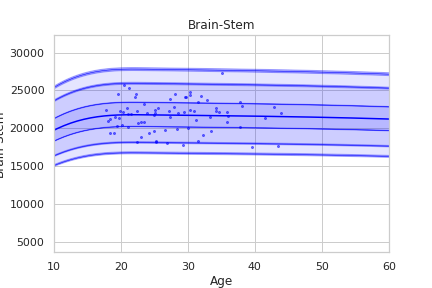

Running IDP 159 Left-Hippocampus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([353.04361874]), 'Rho': array([0.44647854]), 'pRho': array([1.12664462e-07]), 'SMSE': array([0.82974554]), 'EXPV': array([0.19564954])}


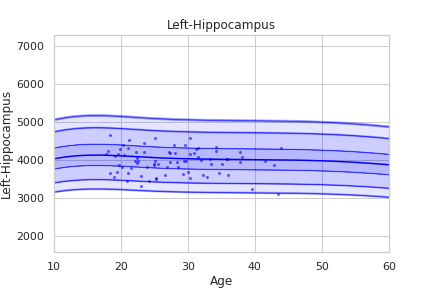

Running IDP 160 Left-Amygdala :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([179.89359673]), 'Rho': array([0.39562198]), 'pRho': array([3.80228391e-06]), 'SMSE': array([0.87609914]), 'EXPV': array([0.15239203])}


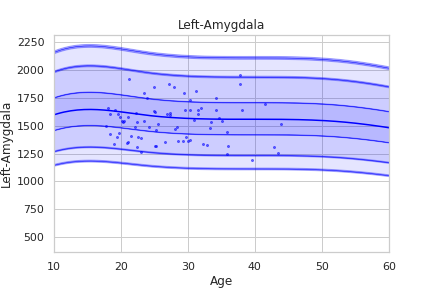

Running IDP 161 CSF :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([198.44642075]), 'Rho': array([0.28715718]), 'pRho': array([0.00110038]), 'SMSE': array([0.96577045]), 'EXPV': array([0.08245262])}


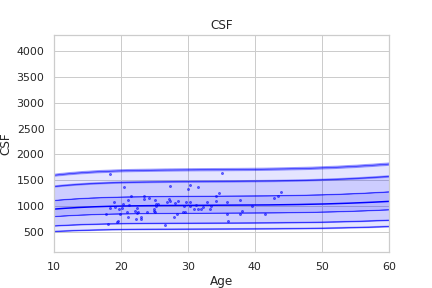

Running IDP 162 Left-Accumbens-area :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([85.23768832]), 'Rho': array([0.31289325]), 'pRho': array([0.00034899]), 'SMSE': array([0.90848459]), 'EXPV': array([0.09751917])}


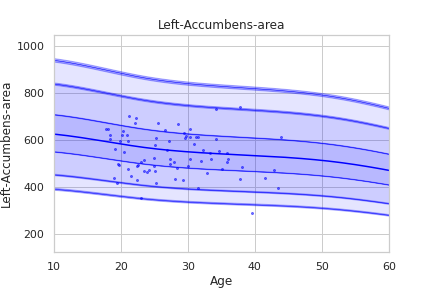

Running IDP 163 Left-VentralDC :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([381.12395081]), 'Rho': array([0.51338618]), 'pRho': array([3.69913939e-10]), 'SMSE': array([0.74231547]), 'EXPV': array([0.25769238])}


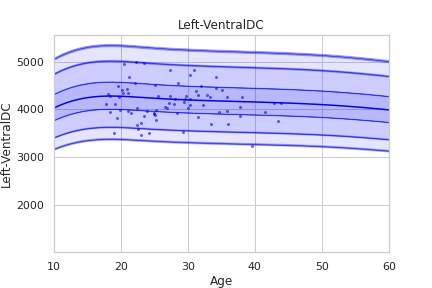

Running IDP 164 Left-vessel :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([19.42914241]), 'Rho': array([0.16657956]), 'pRho': array([0.06327715]), 'SMSE': array([1.16660897]), 'EXPV': array([0.02562359])}


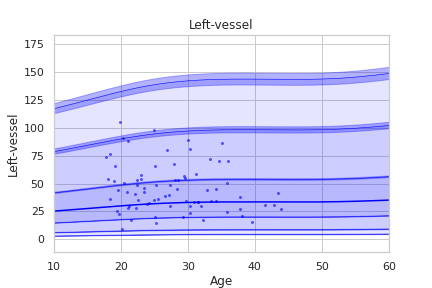

Running IDP 165 Left-choroid-plexus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([122.01016151]), 'Rho': array([0.37348026]), 'pRho': array([1.45840912e-05]), 'SMSE': array([0.86812888]), 'EXPV': array([0.13940789])}


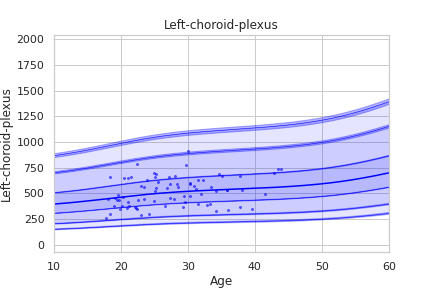

Running IDP 166 Right-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2936.57739543]), 'Rho': array([0.23044907]), 'pRho': array([0.00954351]), 'SMSE': array([0.98500939]), 'EXPV': array([0.05011455])}


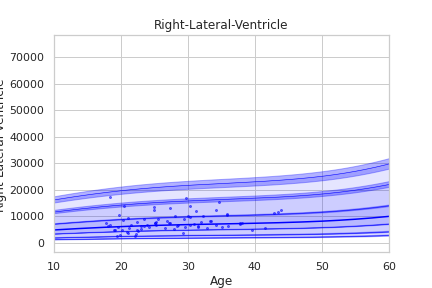

Running IDP 167 Right-Inf-Lat-Vent :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([154.40020888]), 'Rho': array([0.15314879]), 'pRho': array([0.08819478]), 'SMSE': array([1.0078888]), 'EXPV': array([0.00977517])}


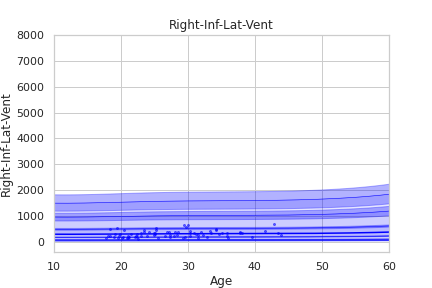

Running IDP 168 Right-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2037.5645287]), 'Rho': array([0.50290386]), 'pRho': array([9.9547849e-10]), 'SMSE': array([0.84546609]), 'EXPV': array([0.16230544])}


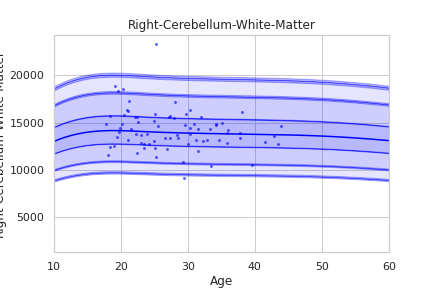

Running IDP 169 Right-Cerebellum-Cortex :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([5720.91625213]), 'Rho': array([0.58433332]), 'pRho': array([1.47336131e-13]), 'SMSE': array([0.67150365]), 'EXPV': array([0.33079956])}


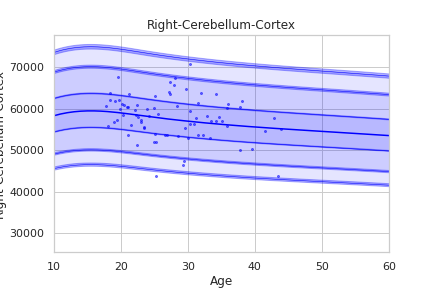

Running IDP 170 Right-Thalamus-Proper :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([664.13429451]), 'Rho': array([0.57094879]), 'pRho': array([7.62908608e-13]), 'SMSE': array([0.70008026]), 'EXPV': array([0.31655785])}


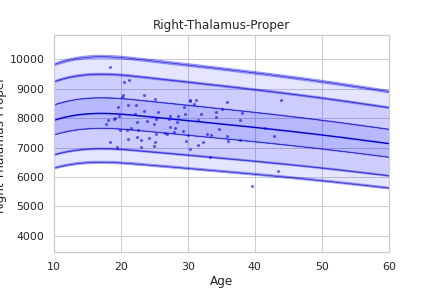

Running IDP 171 Right-Caudate :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([483.7507072]), 'Rho': array([0.28261997]), 'pRho': array([0.00133208]), 'SMSE': array([0.93627313]), 'EXPV': array([0.06376516])}


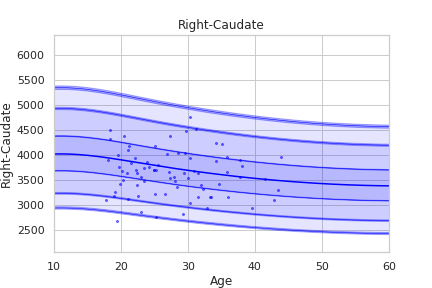

Running IDP 172 Right-Putamen :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([568.80421859]), 'Rho': array([0.36605107]), 'pRho': array([2.23696382e-05]), 'SMSE': array([0.89700646]), 'EXPV': array([0.11524566])}


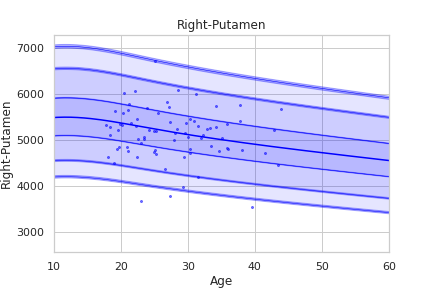

Running IDP 173 Right-Pallidum :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([247.36859066]), 'Rho': array([0.4040444]), 'pRho': array([2.21619264e-06]), 'SMSE': array([0.92426297]), 'EXPV': array([0.15908524])}


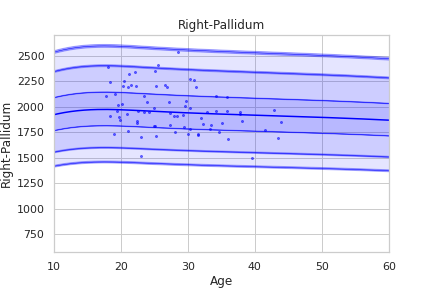

Running IDP 174 Right-Hippocampus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([399.86510358]), 'Rho': array([0.32124427]), 'pRho': array([0.00023463]), 'SMSE': array([0.92376563]), 'EXPV': array([0.10228872])}


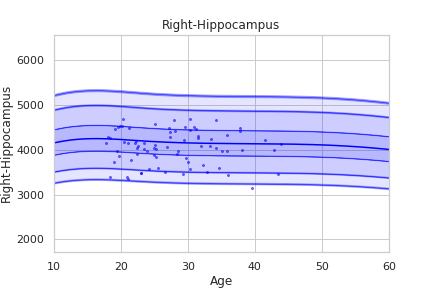

Running IDP 175 Right-Amygdala :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([193.47238967]), 'Rho': array([0.45814057]), 'pRho': array([4.57817876e-08]), 'SMSE': array([0.80632632]), 'EXPV': array([0.20988288])}


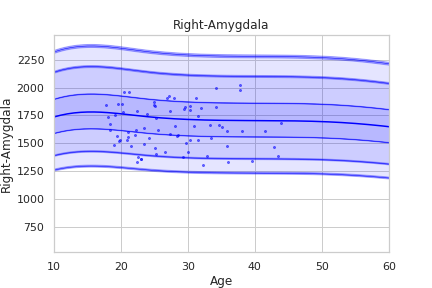

Running IDP 176 Right-Accumbens-area :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([79.5465312]), 'Rho': array([0.32284377]), 'pRho': array([0.00021714]), 'SMSE': array([0.92454565]), 'EXPV': array([0.09748548])}


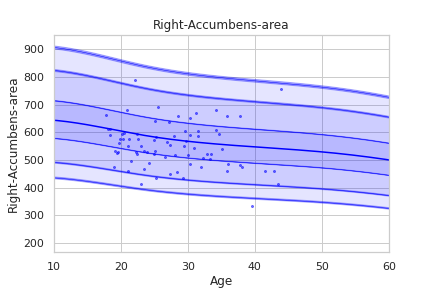

Running IDP 177 Right-VentralDC :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([379.77247491]), 'Rho': array([0.51657317]), 'pRho': array([2.71688776e-10]), 'SMSE': array([0.73892504]), 'EXPV': array([0.2614858])}


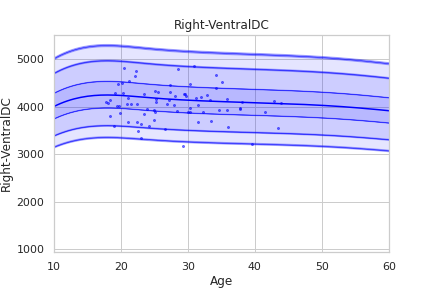

Running IDP 178 Right-vessel :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([19.95542683]), 'Rho': array([-0.00381273]), 'pRho': array([0.96640848]), 'SMSE': array([1.09664802]), 'EXPV': array([-0.00329346])}


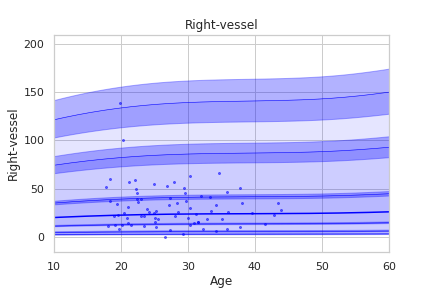

Running IDP 179 Right-choroid-plexus :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([128.37838759]), 'Rho': array([0.27832853]), 'pRho': array([0.00159112]), 'SMSE': array([0.94325559]), 'EXPV': array([0.05728686])}


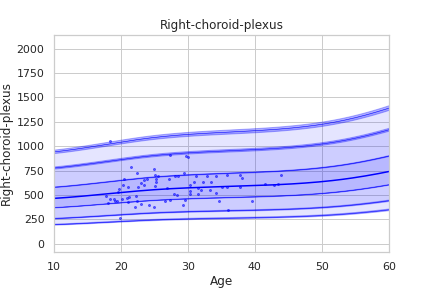

Running IDP 180 SubCortGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([4703.27059854]), 'Rho': array([0.51654469]), 'pRho': array([2.72443397e-10]), 'SMSE': array([0.73365592]), 'EXPV': array([0.2668164])}


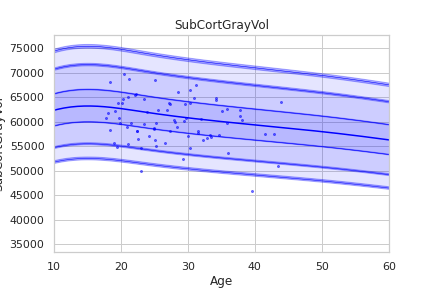

Running IDP 181 TotalGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([53360.53340671]), 'Rho': array([0.66100405]), 'pRho': array([1.68513154e-18]), 'SMSE': array([0.57502957]), 'EXPV': array([0.43530327])}


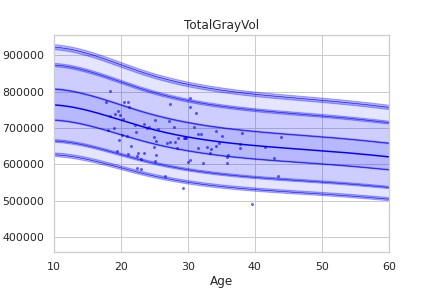

Running IDP 182 SupraTentorialVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([90436.18483976]), 'Rho': array([0.5660059]), 'pRho': array([1.37055594e-12]), 'SMSE': array([0.69524507]), 'EXPV': array([0.32017771])}


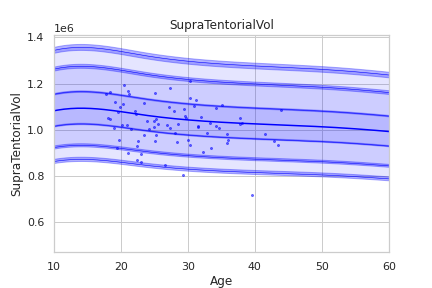

Running IDP 183 SupraTentorialVolNotVent :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([88109.75811595]), 'Rho': array([0.57126921]), 'pRho': array([7.3419312e-13]), 'SMSE': array([0.69106367]), 'EXPV': array([0.3256994])}


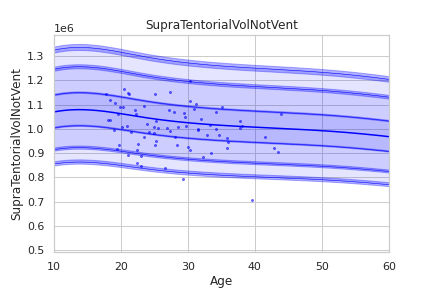

Running IDP 184 EstimatedTotalIntraCranialVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([133495.52747102]), 'Rho': array([0.59512876]), 'pRho': array([3.6647103e-14]), 'SMSE': array([0.66624018]), 'EXPV': array([0.34726459])}


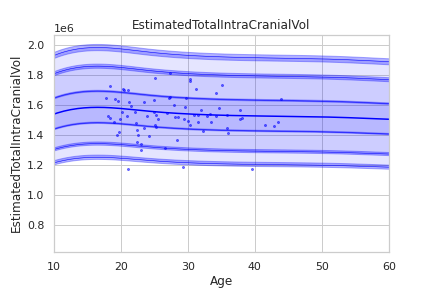

In [29]:
###
# Plotting normative models
###

sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    idp_visit_dir = os.path.join(visit_dir,idp)
    os.chdir(idp_visit_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_visit_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_visit_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_visit_dir, 'resp_te.txt'))
            
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    
    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set
            
            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue
            
            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 
            
            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]
            
            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_visit_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_visit_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue
            
            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
            
            # save transformed predictions so that we don't have to sompute this ever again
            y_te_rescaled_f = os.path.join(idp_visit_dir,'y_rescaled_'+str(sex)+'.txt')
            np.savetxt(y_te_rescaled_f,y_te_rescaled)

            #s2_rescaled_f = os.path.join(idp_visit_dir,'s2_rescaled_'+str(sex)+'.txt')
            #np.savetxt(s2_rescaled_f,s2_rescaled)

        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 0.5)
       
    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((10,60))
    plt.savefig(os.path.join('centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(idp_visit_dir)

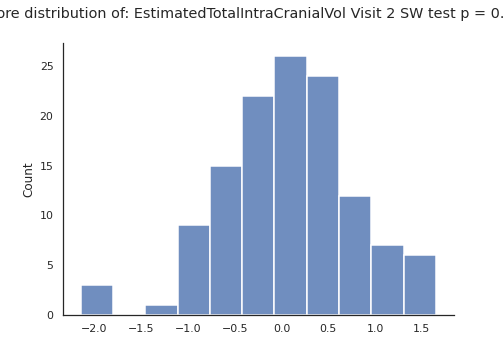

In [72]:
to_load=os.path.join(visit_dir, idp, 'Z_predict.txt')
z_score = pd.read_csv(to_load, header=None)

# Description of the clinics - Visit 1
stat,p = shapiro(z_score)

sns.set_style("white")
fig, axes = plt.subplots(1, figsize=(7,5))
fig.suptitle('Z_score distribution of: '+ idp+ ' Visit ' +str(visit)+ ' SW test p = '+str(round(p,ndigits=4)))
sns.histplot(data=z_score, alpha=.8, linewidth=1.5, legend=False)
sns.despine()



In [199]:
v1_pat.shape

(239, 221)

In [73]:
# Copy all Z-scores files into one directory in bash, then continue with this script
z_dir = os.path.join(visit_dir,'deviation_scores')
filelist = [name for name in os.listdir(z_dir)]
os.chdir(z_dir)
Z_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)
Z_df.index = df_te.index

In [74]:
# Merge and save the data
df_te_Z = pd.merge(df_te, Z_df, how='inner', left_index=True, right_index=True)
df_te_Z.to_csv(os.path.join(visit_dir,'te_Z.csv'), index=True)